**Note: Please create a local copy of this notebook on your Google account before using it**

First, mount your Google Drive to the Colab instance.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download required data files from GitHub repository.

In [2]:
from os import path
if not path.exists("/content/drive/MyDrive/Data-Science-for-Buildings-and-Energy/datasets/heatingload_case5.csv"):
  !mkdir /content/drive/MyDrive/Data-Science-for-Buildings-and-Energy/
  !git clone https://github.com/henze-research-group/Data-Science-for-Buildings-and-Energy.git /content/drive/MyDrive/Data-Science-for-Buildings-and-Energy/

# **Data Science for Buildings and Energy**

Authors: Thibault Marzullo and Gregor Henze

Revised: October 13, 2021

## **Introduction**

This notebook explores the application of several data science (machine learning) approaches to the problem of predicting 24-hour heating load profiles of a hydronic radiant heating system in a five-zone home, shown in Figure 1, given 30 days of past measurements of external air temperature (Text) and global horizontal irradiation (GHI). The objective is to provide a high-level introduction to the application of these approaches.
The home has been modeled using a detailed building energy modeling program (TRNSYS), and represents a residential apartment located in Bolzano (Italy), with a good insulation level and 62.6 m² of heated area. 

The approaches presented here are, in order of appearance:

1. Multilinear regression:
 * Ordinary least squares
 * Least absolute shrinkage and selection operator (Lasso)
 * Ridge regression

2. Regression trees:
 *   Single regression tree and tree pruning
 *   Tree bootstrap aggregation (bagging and random patches)
 *   Random forest
 *   Boosting

3. Support vector regression

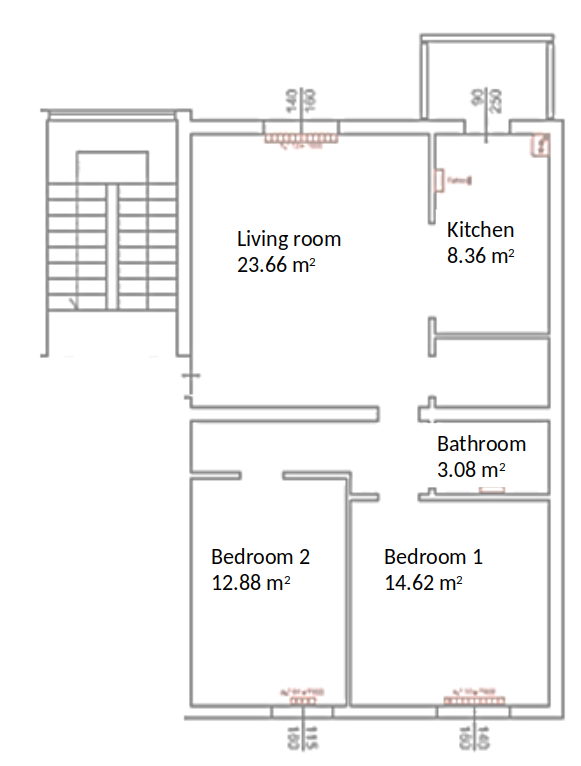

Figure 1: The floor plan of the house modeled in the building energy modeling program TRNSYS used in this analysis


## **Setup**

We load required libraries including matplotlib, pandas, numpy, math, and scikit-learn.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from datetime import datetime

from sklearn import tree
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance

Here, we define a few useful functions.

In [4]:
def cvrmse(y_hat : np.ndarray, y : np.ndarray, **kwargs):
    """
    Coefficient of Variation based on the Root Mean Squared Error.

    Parameters
    ----------
    y_hat : np.ndarray of shape (nSamples,) or (nSamples, nSignals)
        The estimated signals.
    y : np.ndarray of shape (nSamples,) or (nSamples, nSignals)
        The reference signals.
    **kwargs : keyword arguments
        Other arguments to be passed to mean_squared_error. 

    Returns
    -------
    Coefficient of variation of the signals as a percentage.
    """

    e = y_hat - y
    rmse = np.sqrt(np.sum(e*e, axis = 0)/e.shape[0])
    return rmse*100./y.mean()

def nmbe(y_hat : np.ndarray, y : np.ndarray, **kwargs):
    """
    Normalized Mean Bias Error.

    Parameters
    ----------
    y_hat : np.ndarray of shape (nSamples,) or (nSamples, nSignals)
        The estimated signals.
    y : np.ndarray of shape (nSamples,) or (nSamples, nSignals)
        The reference signals.
    **kwargs : keyword arguments
        Other arguments to be passed to mean_squared_error. 

    Returns
    -------
    Normalized mean bias error of the signals as a percentage.
    """
    e = y_hat - y
    return np.sum(e, axis=0)*100./y.mean()

def gof(y_hat : np.ndarray, y : np.ndarray, w_cvrmse = 1, w_nmbe = 3, **kwargs):
    """
    Goodness of Fit.

    Parameters
    ----------
    y_hat : np.ndarray of shape (nSamples,) or (nSamples, nSignals)
        The estimated signals.
    y : np.ndarray of shape (nSamples,) or (nSamples, nSignals)
        The reference signals.
    w_cvrmse : float or int
        Weighting factor for CV(RMSE).
    w_nmbe : float or int
        Weighting factor for NMBE.
    **kwargs : keyword arguments
        Other arguments to be passed. 

    Returns
    -------
    Goodness of fit of the estimate relative to the reference signal.
    """
    # default weights are set according to ASHRAE Guideline 14
    return np.sqrt(((w_cvrmse * cvrmse(y_hat, y))**2 + (w_nmbe * nmbe(y_hat, y))**2)/(w_cvrmse**2 + w_nmbe**2))


# Simple plotting (10 days at once)

def singlePredPlot(y_test_m, predictions, labels, testxlabels, step, length = 10):
  '''
  Helper function that plots one or multiple predictions for a visual
  performance comparison between several prediction methods.

  Parameters
  ----------
  y_test_m : np.ndarray of shape (nSamples,)
      Ground truth.
  predictions : np.ndarray of shape (nSamples,) or list of np.ndarrays
      Predictions. 
  labels : list of strings
      Names used for plotting the predictions. 
  testxlabels : list of datetimes
      Dates used for the x axis labels.
  step : int
      Timestep used in the dataset, used to place labels on the x axis.

  Returns
  -------
  Nothing.
  '''
  plt.figure(figsize=(20,5))
  xaxis = np.arange(0,len(y_test_m),1)
  if not isinstance(labels, str):
    plt.plot(xaxis, y_test_m, label='Ground truth', linestyle='--')
    title = labels[0] + ' ' + ' '.join(["vs. " + labels[i] for i in range(1, len(labels))])
    plt.title(title) 
    for i in range(len(labels)):
      if i == 0:
        plt.plot(xaxis, predictions[i], label=labels[i], linewidth = 3)
      else:
        plt.plot(xaxis, predictions[i], label=labels[i])
       
  else:
    plt.plot(xaxis, y_test_m, label='Ground truth', linestyle='--')
    plt.plot(xaxis, predictions, label=labels, linewidth=3, color='b')
    plt.title(labels)
  plt.legend()
  plt.xlabel("Date")
  plt.ylabel("Power demand (W)")
  plt.xticks(ticks=[i*24*3600/step for i in range(length + 1)], labels=testxlabels)
  plt.grid()
  plt.show()
  return None


def multiPredPlot(y_test_m, results, label, testxlabels, step):
  '''
  Helper function that plots a series of predictions against ground truth.

  Parameters
  ----------
  y_test_m : np.ndarray of shape (nSamples,)
      Ground truth.
  results : list of np.ndarrays
      Prediction. 
  label : string
      Name used for plotting the prediction. 
  testxlabels : list of datetimes
      Dates used for the x axis labels.
  step : int
      Timestep used in the dataset, used to place labels on the x axis.

  Returns
  -------
  Nothing.
  '''
  xresults = [[i+j*24*3600/step for i in range(len(results[0]))] for j in range(len(results))]
  xtesting = [i for i in range(len(y_test_m))]
  global_results = [item for sublist in results for item in sublist]
  
  plt.figure(figsize=(20, 5))
  plt.xlabel("Date")
  plt.ylabel("Power demand (W)")

  for i in range(len(results)):
      plt.plot(xresults[i], results[i], 'x')
  plt.plot(xtesting, y_test_m, label='Ground truth')
  plt.title("%s, CV(RMSE) = %.3f%%" % (label, cvrmse(global_results, y_test_m)))
  plt.legend()
  plt.xticks(ticks=[i*24*3600/step for i in range(11)], labels=testxlabels)

  plt.grid()
  plt.show()
  return None

def predictWithRetraining(method, name = "Missing name", horizon = Horizon, 
                          inp = inp, out = out, X_test_m = X_test_m, 
                          y_test_m = y_test_m, Start = Start, 
                          Training = Training, Interval = Interval, 
                          Horizon = Horizon, testxlabels = testxlabels, step = step):
  '''
  Make a prediction using the prediction algorithm "method", for "Horizon" days, re-training
  the prediction algorithm at "Interval" days of interval.

  Parameters
  ----------
  method : sklearn predictor object
    Predictor used in this function. Can be any Sklearn object that has a .fit() and a .predict() method.
  name : string
    Name of the predictor, for plotting
  Horizon : int
    Forecast horizon, in days.

  TODO: complete this guide
  
  '''
  results = []
  day = int(24 * 3600 / step)
  trainlen = day * Training
  testlen = day * Interval
  start_day = abs((datetime.strptime(Start, "%Y-%m-%d") - inp.index[0]).days) * day


  for k in range(Horizon):
    # One-step ahead forecast, repeated for the length of the test vector
    x_train_moving = inp.iloc[start_day + k * testlen : start_day + 
                              trainlen + k * testlen]
    y_train_moving = out.iloc[start_day + k * testlen : start_day + 
                              trainlen + k * testlen]
    method.fit(x_train_moving, y_train_moving)
    x_test = X_test_m.iloc[k * testlen : k * testlen + testlen].copy()
    results.append(method.predict(x_test.to_numpy()))  
    
  multiPredPlot(y_test_m, results, name, testxlabels, step)
  return results

## **Pre-processing, part 1: formatting the data**

All datasets are provided with a 5-minute resolution. Three datasets are available, representing the same system with varying levels of modeling complexity.

1.   Case 5 (Test 20): Ideal heating loads without internal gains
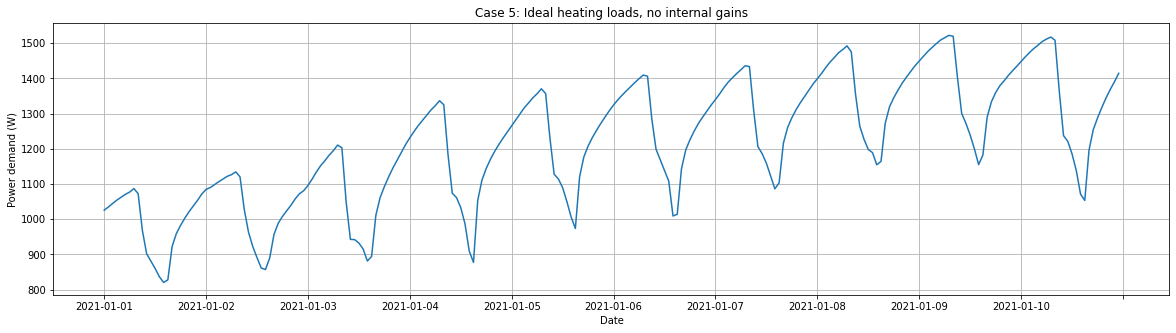
2.   Case 6 (Test 23): Ideal heating loads with internal gains
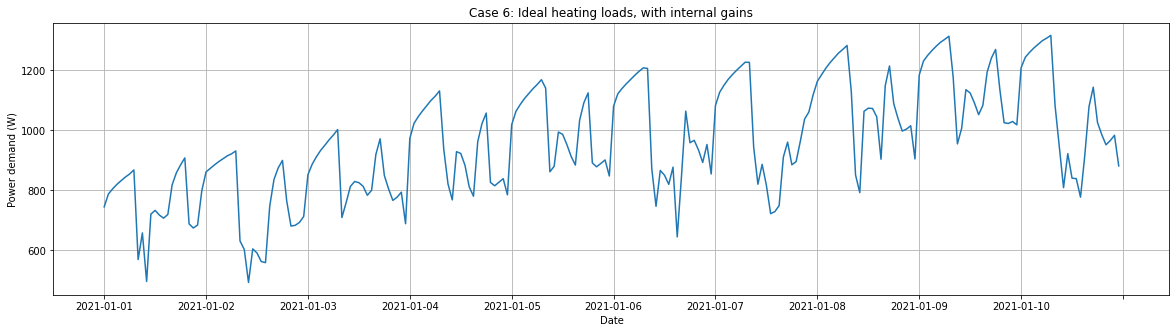
3.   Case 7 (Test 32): Realistic heating loads with internal gains
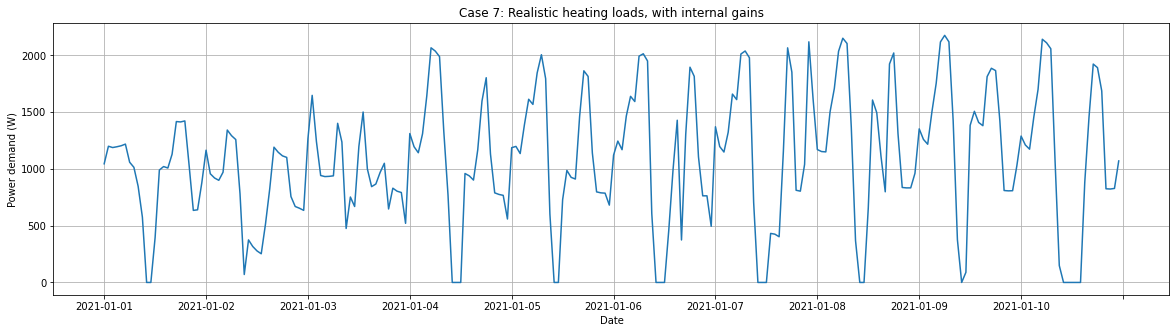

The dataset will be filtered to average data at varying intervals (1-hour, 30-minutes, 15-minutes and 5-minutes) for two predictors only: external air temperature (Text) and global horizontal irradiance (GHI).

Additionally, this code generates new predictors for extracting:
* Hourly values for **past** 24 hours of GHI
* Hourly values for **past** 24 hours of Text

You can inspect the code below by clicking the arrow on the top left corner of this text box, and collapse it again for readability.



**Loading the data:**

In [5]:
#@title Select a test case { run: "auto" }
Testcase = 'Case 6 - Ideal loads, with internal gains' #@param ["Case 5 - Ideal loads, no internal gains", "Case 6 - Ideal loads, with internal gains", "Case 7 - Realistic loads, with internal gains"]
case = Testcase

#@markdown Select how many hours into the past the input variables will be lagged
hours_into_the_past= 24 #@param {type:"integer"}
#@markdown Check the box below if you want the variables to be lagged at hourly intervals, and uncheck it if you want lags at the maximum sampling frequency (ex: if the box is unchecked, a 15-minute frequency will result in 4 lagged variables per hour into the past. If it is checked, the lags will be at hourly intervals regardless of the sampling frequency.)
hourly_lag = True #@param {type:"boolean"}

In [6]:
def caseSelect(case = Testcase):  

  '''
  Extract a Pandas DataFrame from a CSV file present in the GitHub repository.

  Parameters
  ----------
  case : string
    Case name.

  Returns
  -------
  data : DataFrame
    The raw dataset, extracted from the corresponding csv file.
  '''
  if case == "Case 5 - Ideal loads, no internal gains":
    filename = "/content/drive/MyDrive/Data-Science-for-Buildings-and-Energy/datasets/heatingload_case5.csv"
  elif case == "Case 6 - Ideal loads, with internal gains":
    filename = "/content/drive/MyDrive/Data-Science-for-Buildings-and-Energy/datasets/heatingload_case6.csv"
  elif case == "Case 7 - Realistic loads, with internal gains":
    filename = "/content/drive/MyDrive/Data-Science-for-Buildings-and-Energy/datasets/heatingload_case7.csv"
  else:
    "Error: case does not exist."

  data = pd.read_csv(filename, delimiter=',', header = [0, 1])
  data = pd.DataFrame(data)
  data.columns = data.columns.droplevel(level = 1) # The header is split across 2 rows. We drop the second row manually.

  print("Original dataset")
  print(data)

  return data

Original dataset
             TIME   T_EXT  ...  Total heating load   Total cooling load 
0        744.0000  4.8458  ...           505.106417                  0.0
1        744.0833  4.7583  ...           668.633972                  0.0
2        744.1667  4.6750  ...           687.746333                  0.0
3        744.2500  4.5917  ...           689.465694                  0.0
4        744.3333  4.5083  ...           691.170111                  0.0
...           ...     ...  ...                  ...                  ...
105116  9503.6667  5.2125  ...           500.474972                  0.0
105117  9503.7500  5.1208  ...           501.838028                  0.0
105118  9503.8333  5.0292  ...           503.171806                  0.0
105119  9503.9167  4.9375  ...           504.478944                  0.0
105120  9504.0000  4.8458  ...           505.106278                  0.0

[105121 rows x 67 columns]


In [ ]:
data_presampling = caseSelect()

**Resampling data set:**

Resample the dataset from a 5-minute frequency (5T) to a new frequency defined in by `sampling` by computing the mean value of intermediate samples.
See [the usage of the .resample() method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html)
and
[the explanation for the 5T and H string objects used to set the frequency.](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)

NOTE: Do not run this several times in a row, or the data frame will be resampled multiple times. Run block 50 again should this happen. 

In [7]:
#@title Select the sampling frequency { run: "auto" }
Sampling = '1-hour' #@param ["1-hour", "30-minutes", "15-minutes", "5-minutes"]
sampling = Sampling

In [8]:
def resampleData(sampling = sampling, data = data_presampling):

  '''
  Resample a Pandas DataFrame.

  Parameters
  ----------
  sampling : string
    Sampling frequency for the new DataFrame.
  data : DataFrame
    Dataset to resample.

  Returns
  -------
  new : DataFrame
    The resampled dataset.
  step : int
    The timestep (in seconds) after resampling.
  '''
  data['DateTimeIndex'] = pd.date_range('2/1/2020', periods=len(data[data.columns[0]]), freq='5T') # Create datetime index
  data.set_index('DateTimeIndex', inplace=True) # Replace the current dataframe index with the one just created. It makes it slightly easier to use the resample() method.

  if sampling == "15-minutes":
    print("Using sampling of %s" % sampling)
    data = data.resample('15T').mean() # Resample the data at 15-minutes frequency using the mean value
    step = 900
  elif sampling == "30-minutes":
    print("Using sampling of %s" % sampling)
    data = data.resample('30T').mean() # Resample the data at a 30-minutes frequency using the mean value
    step = 1800
  elif sampling == "1-hour":
    step = 3600
    print("Using sampling of %s" % sampling)
    data = data.resample('H').mean() # Resample the data at a hourly frequency using the mean value
  else:
    print("Using sampling of %s" % sampling)
    step = 300
  # Note how the "TIME" column is averaged to the mean value of the decimal hour. This means that the value at time t is computed using the mean of the values between t and t + 1 hour. 
  new = pd.DataFrame()
  new['Qdot_0'] = data['Total heating load ']
  new['Text_0'] = data['T_EXT']
  new['GHI_0'] = data['IRR_HOR']
#  new['hour_year'] = data['TIME']
  return new, step

Using sampling of 1-hour
                         Qdot_0    Text_0  GHI_0
DateTimeIndex                                   
2020-02-01 00:00:00  677.237076  4.383675    0.0
2020-02-01 01:00:00  720.023637  3.341325    0.0
2020-02-01 02:00:00  746.119741  2.283675    0.0


In [ ]:
data, step = resampleData()
print(data.head(3))

Add a window of past values as additional predictors based on the selected horizon of past predictors.

In [9]:
def generateLagged(hours_into_the_past = hours_into_the_past, hourly_lag = hourly_lag, step = step, data = data):

  '''
  Generate lagged predictors.
  Note: currently, the predictors are hardcoded. They are Text and GHI.

  Parameters
  ----------
  hours_into_the_past : int
    Lag horizon. The lagged variables will span from time t = t0 - hours_into_the_past to time t = t0.
  hourly_lag : Bool
    If True, generate lags that are strictly hourly (ex: t - 1 hour, t - 2 hours, etc.).
    Else, generate lags that depend on the sampling frequency (ex: 15-minutes frequency 
    will generate 4 lags per hour).
  step : int
    Step size, in seconds, in this dataset.
  data : DataFrame
    Original dataset

  Returns
  -------
  data : DataFrame
    The new dataset, which now includes lagged predictors.
  '''
  # in case of repeated use of this function, keep only base columns
  if len(data.columns) > 3:
    data = data.copy()[['Qdot_0', 'Text_0', 'GHI_0']]

  lags = int(hours_into_the_past * 3600 / step + 1)
  

  for i in range(1, lags):
    if hourly_lag:
      if i % (3600 / step) == 0:
        data['Text_-'+str(int(i / (3600 / step)))] = data['Text_0'].shift(periods=i)
        data['GHI_-'+str(int(i / (3600 / step)))] = data['GHI_0'].shift(periods=i)
    else:
      data['Text_-'+str(i)] = data['Text_0'].shift(periods=i)
      data['GHI_-'+str(i)] = data['GHI_0'].shift(periods=i)
  data = data.iloc[lags - 1:] # Shifting columns generates 24 rows with missing values. This line drops these rows with missing data.
  print("For 24 hours, we introduce %d lags" % int((len(data.columns) - 3)/2))
  return data

For 24 hours, we introduce 24 lags


In [ ]:
data = generateLagged()

Inspect the new dataset:

In [10]:
print("New dataset")
print(data)
print(data.columns)

New dataset
                         Qdot_0    Text_0  GHI_0  ...  GHI_-23  Text_-24  GHI_-24
DateTimeIndex                                     ...                            
2020-02-02 00:00:00  722.369880 -0.207292    0.0  ...      0.0  4.383675      0.0
2020-02-02 01:00:00  775.818178 -0.666325    0.0  ...      0.0  3.341325      0.0
2020-02-02 02:00:00  801.649255 -1.108675    0.0  ...      0.0  2.283675      0.0
2020-02-02 03:00:00  824.632076 -1.482292    0.0  ...      0.0  1.409375      0.0
2020-02-02 04:00:00  844.611012 -1.725350    0.0  ...      0.0  0.750350      0.0
...                         ...       ...    ...  ...      ...       ...      ...
2021-01-30 20:00:00  516.610898  8.267017    0.0  ...      0.0  2.391325      0.0
2021-01-30 21:00:00  521.413611  7.424650    0.0  ...      0.0  1.933675      0.0
2021-01-30 22:00:00  533.757398  6.482983    0.0  ...      0.0  1.491325      0.0
2021-01-30 23:00:00  482.226014  5.441325    0.0  ...      0.0  1.033675      0.0
2021

## **Pre-processing, part 2: Preparing training and testing data**

This section splits the dataset into two portions: One for training the regression model, another for testing the model's prediction capabilities on unseen data. 

Two methods are shown in the code:
1. Using random samples extracted using sklearn's train_test_split method
2. Manually selecting a 30-day training and a 1-day testing dataset *

** This method is used in this notebook for demonstrating an implementation of an "online" learning approach.*

You can inspect the code below by clicking the arrow on the top left corner of this text box and collapse it again for readability.


**Extracting the testing and training datasets**

In [11]:
#@title Sampling of training and testing data { run: "auto" }
randomsamples = False #@param {type:"boolean"}
#@markdown Check this box if you want to sample the data randomly throughout the dataset. Uncheck it to manually define the training and testing horizons.

#@markdown ---
#@markdown **If `randomsamples` is deselected, please input testing and training horizons below.**

#@markdown Select the number of days of training
Training = 30 #@param {type:"integer"}
#@markdown Select the interval, in days, between two trainings. Ex.: setting this value to 1 will re-train the model every day on the past `Training` days of data.
Interval = 1 #@param {type:"integer"}
#@markdown Select the forecasting horizon, in days
Horizon = 10 #@param {type:"integer"}
#@markdown Select the starting date for forecasts. Valid dates are between March 2nd, 2020 and January 30, 2021
Start = '2020-12-02' #@param {type:"date"}

In [12]:
def generateTrainingAndTesting(randomsamples = randomsamples, Training = Training, Interval = Interval, Horizon = Horizon, Start = Start, step = step, data = data):
  '''
  Generate training and testing datasets.

  Parameters
  ----------
  randomsamples : Bool
    If True, random samples will be picked from the dataset.
  Training : int
    Number of days of training.
  Interval : int
    Interval at which predictions will be made, in days.
  Horizon : int
    Forecast horizon, in days.
  Start : datetime
    Starting date for forecasting.
  step : int
    Step, in seconds, used in the dataset.
  data : DataFrame
    Dataset that contains training and testing data

  Returns
  -------
  X_train : DataFrame
    Inputs for training.
  y_train : DataFrame
    Outputs for training.
  X_test : DataFrame
    Inputs for testing, short prediction of "Interval" days
  y_test : DataFrame
    Outputs for testing, short prediction of "Interval" days
  X_test_m : DataFrame
    Inputs for testing, long prediction of "Interval * Horizon" days
  y_test_m : DataFrame
    Outputs for testing, long prediction of "Interval * Horizon" days
  trainxlabels : list of datetimes
    Labels for plotting training data
  testxlabels : list of datetimes
    Labels for plotting testing data
  inp : DataFrame
    Raw predictors data (not sampled)
  out : DataFrame
    Raw predictions data (not sampled)
  '''
  # Select predicted variable

  out = data['Qdot_0']

  # Select predictors
  predictors = data.columns.tolist()
  predictors.remove('Qdot_0')
  inp = data[predictors]

  if randomsamples:

    X_train, X_test, y_train, y_test = train_test_split(inp, out, random_state=0, test_size = 0.3, train_size = 0.7) # Reserve 30% of the data for testing and 70% for training
    trainxlabels = [i for i in range(len(X_train))]
    testxlabels = [i for i in range(len(X_test))]
    return X_train, y_train, X_test, y_test, trainxlabels, testxlabels, inp, out
  else:
    day = int(24 * 3600 / step)
    trainlen = day * Training
    testlen = day * Interval
    start_day = abs((datetime.strptime(Start, "%Y-%m-%d") - inp.index[0]).days) * day

    X_train = inp.iloc[start_day : start_day + trainlen]
    y_train = out.iloc[start_day : start_day + trainlen]
    # 1-day testing window
    X_test = inp.iloc[start_day + trainlen : start_day  + trainlen + testlen]
    y_test = out.iloc[start_day + trainlen : start_day + trainlen + testlen]
    # 10-day testing window
    X_test_m = inp.iloc[start_day + trainlen : start_day + trainlen + testlen * Horizon]
    y_test_m = out.iloc[start_day + trainlen : start_day + trainlen + testlen * Horizon]

    # Prepare plot labels:
    trainxlabels = [X_train.index[i].date() for i in range(len(X_train.index)) if i % (24*3600/step) == 0]
    testxlabels = [X_test_m.index[i].date() for i in range(len(X_test_m.index)) if i % (24*3600/step) == 0]
    return X_train, y_train, X_test, y_test, X_test_m, y_test_m, trainxlabels, testxlabels, inp, out


In [ ]:
X_train, y_train, X_test, y_test, X_test_m, y_test_m, trainxlabels, testxlabels, inp, out = generateTrainingAndTesting()

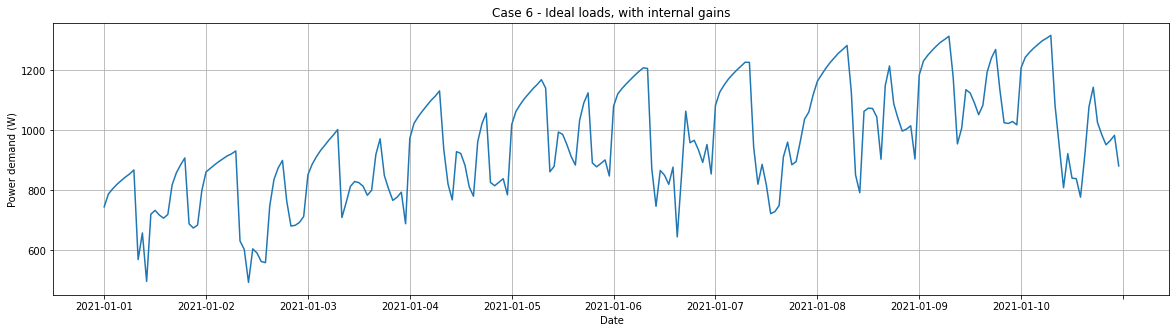

In [13]:
plt.figure(figsize=(20,5))
xaxis = np.arange(0,len(y_test_m),1)
plt.plot(xaxis, y_test_m)
plt.title(Testcase)
plt.xlabel("Date")
plt.ylabel("Power demand (W)")
plt.xticks(ticks=[i*24*3600/step for i in range(Horizon + 1)], labels=testxlabels)
plt.grid()
plt.show()

#**Linear, Lasso and Ridge Regression**

In this section, we are considering simple multilinear, regularized lasso (least absolute shrinkage and selection operator) and ridge regression with its regularization parameter found from $k$-fold cross-validation.

Linear regression has been around for a long time and is the topic of innumerable textbooks. Though it may seem somewhat boring compared to some of the more modern data science approaches, linear regression is still a useful and widely used statistical learning method. Moreover, it serves as a good launching point for newer approaches since many fancy statistical learning approaches can be seen as generalizations or extensions of linear regression. Consequently, the importance of having a good understanding of linear regression before studying more complex learning methods cannot be overstated. 

Suppose that in our role as energy engineers we are asked to suggest, on the basis of data, a model that will result in highly accurate heating load predictions for an apartment. What information would be useful in order to recommend such a model? Here are a few important questions that we might seek to address:

* Is there a relationship between outdoor air temperature and the heating load of an apartment? Our first goal should be to determine whether the data provide evidence of an association between ambient temperature and heating load.

* How strong is the relationship between ambient temperature and heating load? Assuming that there is a relationship between ambient temperature and heating load, we would like to know the strength of this relationship. In other words, given a certain ambient temperature, can we predict heating load with a high level of accuracy? This would be a strong relationship. Or is a prediction of heating load based on ambient temperature only slightly better than a random guess? This would be a weak relationship.

* Which aspects, in addition to ambient temperature, contribute to heating load? Do all ambient temperature, time of day, global horizontal radiation, day of the week and others contribute to the heating load, or do just one or two of these contribute? To answer this question, we must find a way to separate out the individual effects of each suspected influencing variable, which we call predictor, on the response variable, here our heating load.

* How accurately can we estimate the effect of each predictor on the heating load? For unit increase of each predictor, by what amount will the heating load increase? How accurately can we predict this amount of increase?

* How accurately can we predict future heating loads? For any given level of the predictors, what is our prediction for the heating load, and what is the accuracy of this prediction?

* Is the relationship linear? If there is approximately a straight-line relationship between each predictor and the heating load as our response variable, then linear regression is an appropriate tool. If not, then it may still be possible to transform the predictor or the response so that linear regression can be used.

* Are there interaction effects among the predictors? Do pairs of predictor variables interact to affect the response variable in a way that would not be captured by the individual consideration of each of the two predictor variables?

In turns out that linear regression can be used to answer each of these questions.

The multiple linear regression model takes on the form 

\begin{equation}
y = \beta_0 + \sum_{j=1}^p \beta_j x_j + \epsilon
\end{equation}

$X_j$ represents the $j$-th predictor and $\beta_j$ quantifies the association between that variable and the response. We interpret $\beta_j$ as the average effect on $Y$ of a one unit increase in $X_j$, holding all other predictors fixed.

Unfortunately, the true regression coefficients $\beta_0, \beta_1, \ldots, \beta_p$ are unknown, and must be estimated. Given estimates $\hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_p$, we can make predictions using the formula

\begin{equation}
\hat{y} = \hat{\beta}_0 + \sum_{j=1}^p \hat{\beta}_j x_j
\end{equation}

The parameters are estimated using a least squares approach, i.e., we choose each $\hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_p$ to minimize the sum of squared residuals

\begin{equation}
RSS = \sum_{i=1}^n (y_i -\hat{y}_i)^2 = \sum_{i=1}^n (y_i -\hat{\beta}_0 - \sum_{j=1}^p \hat{\beta}_j x_{ij})^2
\end{equation}

The values $\hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_p$ that minimize $RSS$ are the multiple least squares regression coefficient estimates.

In [14]:
from sklearn.linear_model import LinearRegression

lreg = LinearRegression().fit(X_train, y_train)
lreg.score(X_train, y_train)
prediction_lreg = lreg.predict(X_test_m)

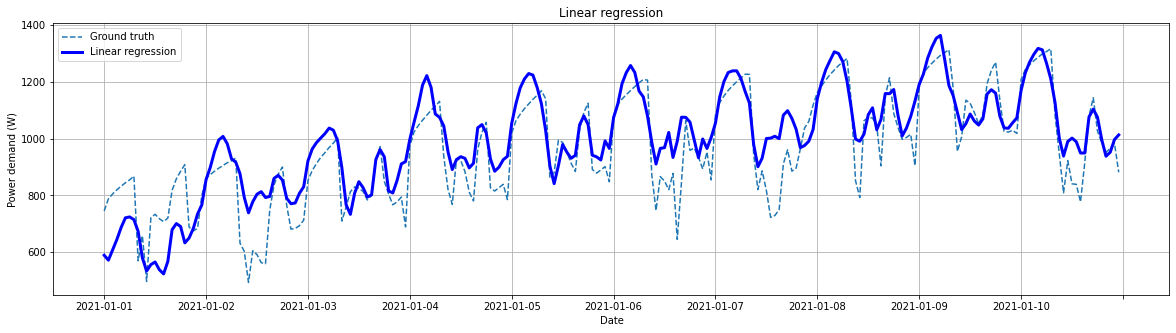

In [15]:
singlePredPlot(y_test_m, prediction_lreg, "Linear regression", testxlabels, step)

In [16]:
print("Linear regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lreg)*100), mean_squared_error(y_test_m, prediction_lreg)))

Linear regression: 	 R² = 68.03 % and MSE = 10815.79 Watts


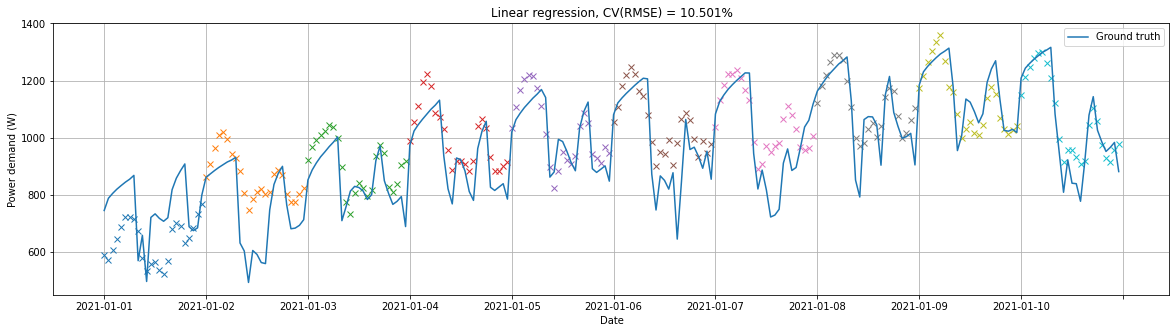

In [ ]:
lreg_results = predictWithRetraining(method = lreg, name = "Linear regression")

Now, we are moving to a lasso (least absolute shrinkage and selection operator) regression. We can fit a model containing all $p$ predictors using a technique that constrains or regularizes the coefficient estimates, or equivalently, that shrinks the coefficient estimates towards zero. It may not be immediately obvious why such a constraint should improve the fit, but it turns out that shrinking the coefficient estimates can significantly reduce their variance. The two best-known techniques for shrinking the regression coefficients towards zero are ridge regression and the lasso.

Recall that the ordinary least squares fitting procedure estimates $\hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_p$ using the values that minimize

\begin{equation}
RSS = \sum_{i=1}^n (y_i -\hat{\beta}_0 - \sum_{j=1}^p \hat{\beta}_j x_{ij})^2
\end{equation}

Lasso regression is very similar to ordinary least squares, except that the coefficients are estimated by minimizing a slightly different quantity. In particular, the lasso regression coefficient estimates $\hat{\beta}^L$ are the values that minimize

\begin{equation}
  RSS + \lambda \sum_{j=1}^p |\hat{\beta}_j |
\end{equation}

In statistical parlance, the lasso uses an $\ell_1$ (pronounced “ell 1”) penalty instead of an $\ell_2$ penalty. The $\ell_1$ norm of a coefficient vector $\hat{\beta}$ is given by $||\hat{\beta}||=\sum |\hat{\beta}_j|$.  As with ridge regression, the lasso shrinks the coefficient estimates towards zero. However, in the case of the lasso, the $\ell_1$ penalty has the effect of forcing some of the coefficient estimates to be exactly equal to zero when the tuning parameter $\lambda$ is sufficiently large. *Hence, much like best subset selection, the lasso performs variable selection.* As a result, models generated from the lasso are generally much easier to interpret than those produced by ridge regression. We say that the lasso yields sparse models, i.e., models that involve only a subset of the variables. As in ridge regression, selecting a good value of $\lambda$ for the lasso is critical. There are very efficient algorithms for fitting both ridge and lasso models; in both cases the entire coefficient paths can be computed with about the same amount of work as a single ordinary least squares fit. 



In [18]:
from sklearn.linear_model import LassoCV

lassoreg = LassoCV(cv=5, max_iter = 5000, random_state=0).fit(X_train, y_train)
lassoreg.score(X_train, y_train)
prediction_lassoreg = lassoreg.predict(X_test_m)

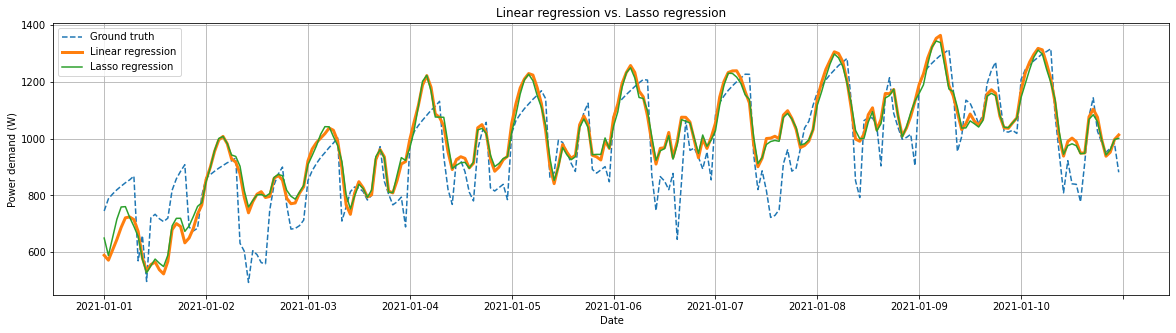

In [19]:
singlePredPlot(y_test_m, [prediction_lreg, prediction_lassoreg], ["Linear regression", "Lasso regression"], testxlabels, step)

In [20]:
print("Linear regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lreg)*100), mean_squared_error(y_test_m, prediction_lreg)))
print("Lasso regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lassoreg)*100), mean_squared_error(y_test_m, prediction_lassoreg)))

Linear regression: 	 R² = 68.03 % and MSE = 10815.79 Watts
Lasso regression: 	 R² = 68.88 % and MSE = 10530.00 Watts


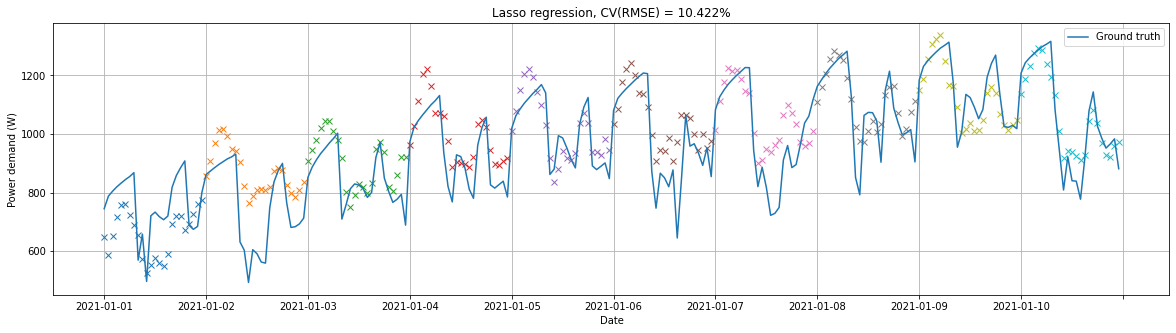

In [21]:
lassoreg_results = predictWithRetraining(method = lassoreg, name = "Lasso regression")

Save the coefficients of the lasso regression, and display them.

In [78]:
coefficients_lassoreg = {}
i = 0
print('Lasso regression coefficients:\n')
for column in X_train.columns.values:
  coefficients_lassoreg[column] = lassoreg.coef_[i]
  if lassoreg.coef_[i] == 0.0:
    print('%s: \t %.3f' % (column, lassoreg.coef_[i])) #\x1b[5;30;41m
  else:
    print('%s: \t %.3f' % (column, lassoreg.coef_[i]))
  i+=1

Lasso regression coefficients:

Text_0: 	 -13.537
GHI_0: 	 -0.163
Text_-1: 	 -0.000
GHI_-1: 	 0.006
Text_-2: 	 -0.000
GHI_-2: 	 0.018
Text_-3: 	 -7.324
GHI_-3: 	 -0.041
Text_-4: 	 -0.000
GHI_-4: 	 -0.049
Text_-5: 	 -0.000
GHI_-5: 	 -0.017
Text_-6: 	 -0.000
GHI_-6: 	 -0.049
Text_-7: 	 -0.000
GHI_-7: 	 0.145
Text_-8: 	 -0.000
GHI_-8: 	 -0.119
Text_-9: 	 -8.242
GHI_-9: 	 -0.094
Text_-10: 	 -1.867
GHI_-10: 	 -0.153
Text_-11: 	 -0.000
GHI_-11: 	 0.045
Text_-12: 	 -0.000
GHI_-12: 	 0.012
Text_-13: 	 -1.771
GHI_-13: 	 0.000
Text_-14: 	 -0.000
GHI_-14: 	 -0.063
Text_-15: 	 -0.000
GHI_-15: 	 -0.024
Text_-16: 	 -0.000
GHI_-16: 	 -0.063
Text_-17: 	 -0.000
GHI_-17: 	 0.024
Text_-18: 	 -0.000
GHI_-18: 	 0.121
Text_-19: 	 -0.000
GHI_-19: 	 -0.125
Text_-20: 	 -0.000
GHI_-20: 	 -0.104
Text_-21: 	 -0.000
GHI_-21: 	 -0.109
Text_-22: 	 -0.000
GHI_-22: 	 0.006
Text_-23: 	 -0.000
GHI_-23: 	 -0.064
Text_-24: 	 -20.463
GHI_-24: 	 0.069


## **Ridge regression**

Ridge regression is again very similar to ordinary least squares, except that the coefficients are estimated by minimizing a slightly different quantity. In particular, the ridge regression coefficient estimates $\hat{\beta}^R$ are the values that minimize

\begin{equation}
  RSS + \lambda \sum_{j=1}^p \hat{\beta}_j^2
\end{equation}

In statistical parlance, the ridge uses an $\ell_2$ (pronounced “ell 2”) penalty instead of an $\ell_1$ penalty that the lasso adopts. The $\ell_2$ norm of a coefficient vector $\hat{\beta}$ is given by $||\hat{\beta}||=\sum \hat{\beta}_j^2$.  As with the lasso, ridge regression shrinks the coefficient estimates towards zero. However, in the case of ridge regression, the $\ell_2$ penalty does not have the effect of forcing some of the coefficient estimates to be exactly equal to zero when the tuning parameter $\lambda$ is sufficiently large, instead the coefficient values merely become very small. *Hence, ridge regression does not perform variable selection.* As in the lasso, selecting a good value of $\lambda$ for ridge regression is critical, which will be accomplished by $k$-fold cross-validation on the test errors. 

In [23]:
from sklearn.linear_model import RidgeCV

ridgereg = RidgeCV(cv = 5, alphas=np.logspace(-6, 10, 17))
ridgereg.fit(X_train, y_train)
prediction_ridgereg = ridgereg.predict(X_test_m)

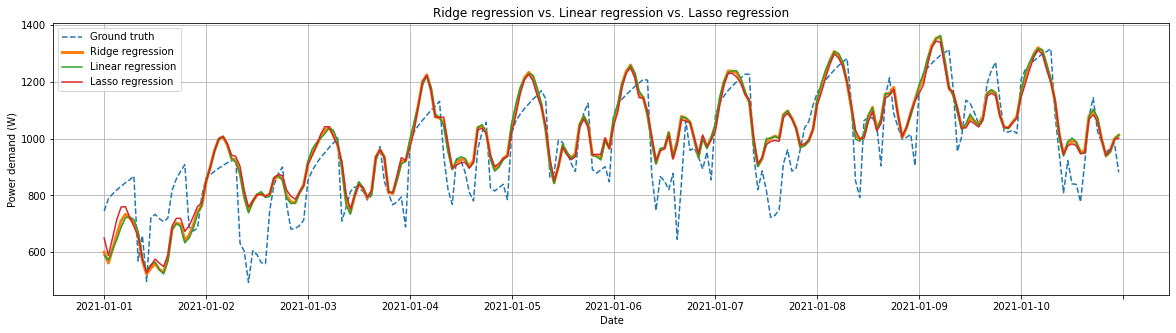

In [24]:
singlePredPlot(y_test_m, [prediction_ridgereg, prediction_lreg, prediction_lassoreg], ["Ridge regression", "Linear regression", "Lasso regression"], testxlabels, step)

In [25]:
print("Linear regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lreg)*100), mean_squared_error(y_test_m, prediction_lreg)))
print("Lasso regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lassoreg)*100), mean_squared_error(y_test_m, prediction_lassoreg)))
print("Ridge regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_ridgereg)*100), mean_squared_error(y_test_m, prediction_ridgereg)))

Linear regression: 	 R² = 68.03 % and MSE = 10815.79 Watts
Lasso regression: 	 R² = 68.88 % and MSE = 10530.00 Watts
Ridge regression: 	 R² = 67.54 % and MSE = 10984.61 Watts


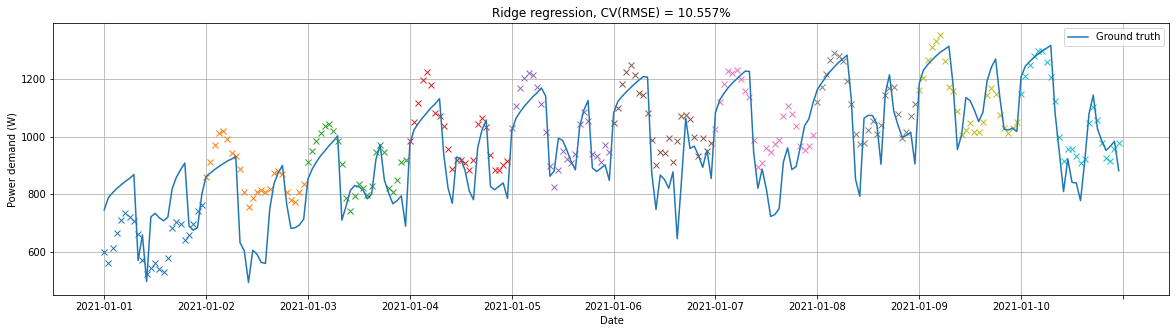

In [26]:
ridgereg_results = predictWithRetraining(method = ridgereg, name = "Ridge regression")

# **Regression Trees**

## **Approach 1: Single Regression Tree and Tree Pruning**

This section demonstrates the use of regression trees for predicting the next 24 hours of heating and cooling load (Qdot), knowing the past 30 days of GHI, Text and Qdot.

This code uses Scikit's `DecisionTreeRegressor` method which is an improved CART method. Read more about it [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html?highlight=decision%20tree%20regressor#sklearn-tree-decisiontreeregressor).

Tree-based methods involve stratifying or segmenting the predictor space into a number of simple regions. In order to make a prediction for a given observation, we typically use the mean or the mode of the training observations in the region to which it belongs. Since the set of splitting rules used to segment the predictor space can be summarized in a tree, these types of approaches are known as decision tree methods. Tree-based methods are simple and useful for interpretation. However, they typically are not competitive with the best supervised learning approaches. Hence, we also introduce bagging, random patches, random forests, and boosting. Each of these approaches involves producing multiple trees, which are then combined to yield a single consensus prediction. We will see that combining a large number of trees can often result in an  improvement in prediction accuracy, at the expense of some loss in interpretation.


**Prediction via Stratification of the Feature Space**

We now discuss the process of building a regression tree. Roughly speaking, there are two steps.
1. We divide the predictor space, i.e., the set of possible values for $X_1, X_2, \ldots , X_p$ into $J$ distinct and non-overlapping regions, $R_1,R_2,\ldots ,R_J$.
2. For every observation that falls into the region $R_j$, we make the same prediction, which is simply the mean of the response values for the training observations in $R_j$. For instance, suppose that in Step 1 we obtain two regions, $R_1$ and $R_2$, and that the response mean of the training observations in the first region is 10, while the response mean of the training observations in the second region is 20. Then for a given observation $X = x$, if $x \in R_1$ we will predict a value of 10, and if $x \in R_2$ we will predict a value of 20.

We now elaborate on Step 1 above. How do we construct the regions $R_1,\ldots,R_J$? In theory, the regions could have any shape. However, we choose to divide the predictor space into high-dimensional rectangles, or boxes, for simplicity and for ease of interpretation of the resulting predictive model. The goal is to find boxes $R_1, \ldots , R_J$ that minimize the residual sum of square ($RSS$), given by

\begin{equation}
  RSS = \sum_{j=1}^J \sum_{i \in R_j} (y_i-\hat{y}_{R_j})^2
\end{equation}


where $\hat{y}_{R_j}$ is the mean response for the training observations within the $j$-th box. Unfortunately, it is computationally infeasible to consider every possible partition of the feature space into $J$ boxes. For this reason, we take a top-down, greedy approach that is known as *recursive binary splitting*. The approach is top-down because it begins at the top of the tree (at which point all observations belong to a single region) and then successively splits the predictor space; each split is indicated via two new branches further down on the tree. It is greedy because at each step of the tree-building process, the best split is made at that particular step, rather than looking ahead and picking a split that will lead to a better tree in some future step.

In order to perform recursive binary splitting, we first select the predictor $X_j$ and the cutpoint $s$ such that splitting the predictor space into the regions $\{X|X_j < s\}$ and $\{X|X_j \geq s\}$ leads to the greatest possible reduction in RSS. (The notation $\{X|X_j < s\}$ means the region of predictor space in which $X_j$ takes on a value less than $s$.) That is, we consider all predictors $X_1, \ldots , X_p$, and all possible values of the cutpoint $s$ for each of the predictors, and then choose the predictor and cutpoint such that the resulting tree has the lowest $RSS$. 

Next, we repeat the process, looking for the best predictor and best cutpoint in order to split the data further so as to minimize the RSS within each of the resulting regions. However, this time, instead of splitting the entire predictor space, we split one of the two previously identified regions. We now have three regions. Again, we look to split one of these three regions further, so as to minimize the $RSS$. The process continues until a stopping criterion is reached; for instance, we may continue until no region contains more than five observations.

Once the regions $R_1,\ldots,R_J$ have been created, we predict the response for a given test observation using the mean of the training observations in the region to which that test observation belongs.


**Basic usage**

In [27]:
# Define and fit a single regression tree with defined random seed for splitting consistency
clf_unpruned = DecisionTreeRegressor(random_state = 0).fit(X_train, y_train)

Plotting the training data and training prediction.

In [28]:
# Predict training data using regression tree trained on the same data
prediction_unpruned_training = clf_unpruned.predict(X_train)

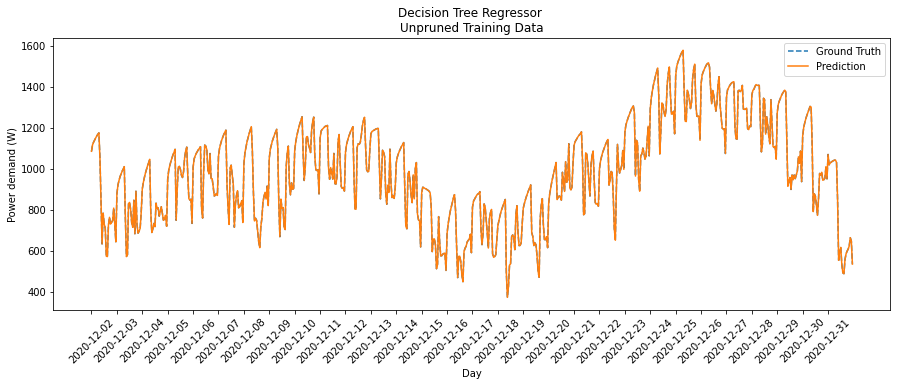

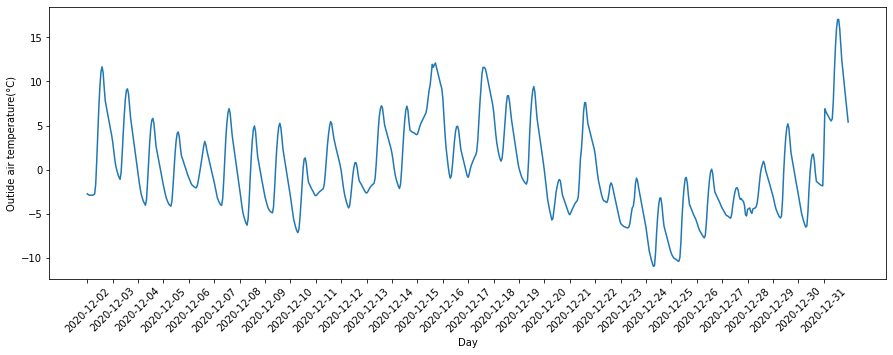

In [29]:
# Plot prediction results
plt.figure(figsize=(15,5))
xaxis = np.arange(0,len(X_train),1)
plt.plot(xaxis, y_train,'--', xaxis,  prediction_unpruned_training)
plt.legend(('Ground Truth','Prediction'))
plt.title('Decision Tree Regressor \nUnpruned Training Data')
plt.xlabel("Day")
plt.ylabel("Power demand (W)")
plt.xticks(ticks=[i for i in range(len(xaxis)) if i % (24 * 3600 / step) == 0], labels = trainxlabels, rotation = 45)
plt.show()
plt.figure(figsize=(15,5))
plt.xlabel("Day")
plt.ylabel("Outide air temperature(°C)")
plt.xticks(ticks=[i for i in range(len(xaxis)) if i % (24 * 3600 / step) == 0], labels = trainxlabels, rotation = 45)
plt.plot(xaxis, X_train['Text_0'])
plt.show()

Plotting the testing data and testing prediction.

In [30]:
# Predict testing data using regression tree trained on training data
prediction_unpruned = clf_unpruned.predict(X_test_m)

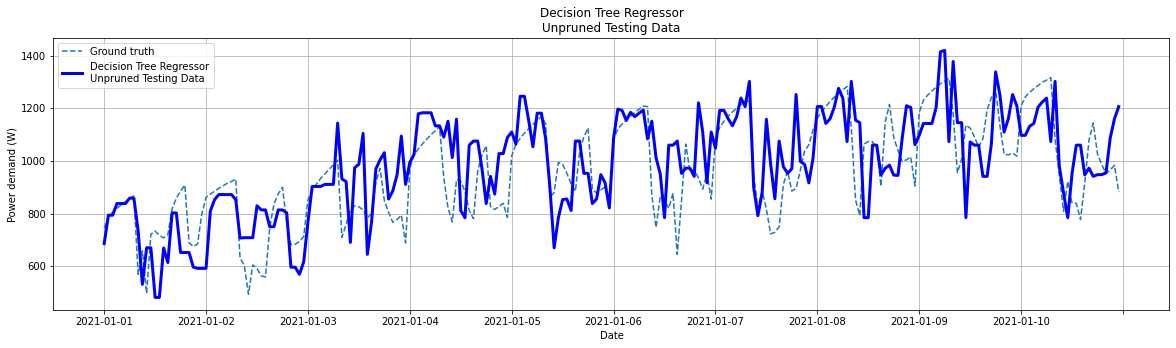

In [31]:
# Plot prediction results
singlePredPlot(y_test_m, prediction_unpruned, "Decision Tree Regressor\nUnpruned Testing Data", testxlabels, step)

This single unpruned tree gives poor performance, but it demostrates the usage of the `DecisionTreeRegressor` method. If the method is called without setting parameters such as the maximum depth (number of internal nodes or splits on the longest branch), this method produces fully-grown decision trees, which are most of the time overly complex and lead to model over-fitting. See below maximum depth and number of leaves in of the unpruned decision tree. This serves as an illustration of how complex the tree can grow.

In [32]:
print("Maximum depth of the unpruned regression tree: ", clf_unpruned.get_depth())
print("Number of leaves of the unpruned regression tree: ", clf_unpruned.get_n_leaves())

Maximum depth of the unpruned regression tree:  20
Number of leaves of the unpruned regression tree:  720


**Tree Pruning**

The process described above may produce good predictions on the training set, but is likely to overfit the data, leading to poor test set performance. This is because the resulting tree might be too complex. A smaller tree with fewer splits (that is, fewer regions $R_1,\ldots,R_J$) might lead to lower variance and better interpretation at the cost of a little bias. One possible alternative to the process described above is to build the tree only so long as the decrease in the RSS due to each split exceeds some (high) threshold. This strategy will result in smaller trees, but is too short-sighted since a seemingly worthless split early on in the tree might be followed by a very good split—that is, a split that leads to a large reduction in RSS later on.

Therefore, a better strategy is to grow a very large tree $T_0$, and then prune it back in order to obtain a subtree. How do we determine the best way to prune the tree? Intuitively, our goal is to select a subtree that leads to the lowest test error rate. Given a subtree, we can estimate its test error using cross-validation or the validation set approach. However, estimating the cross-validation error for every possible subtree would be too cumbersome, since there is an extremely large number of possible subtrees. Instead, we need a way to select a small set of subtrees for consideration.

*Cost complexity pruning* gives us a way to do just this. Rather than considering every possible subtree, we consider a sequence of trees indexed by a nonnegative tuning parameter $\alpha$.

For each value of $\alpha$ there corresponds a subtree $T ⊂ T_0$ such that

\begin{equation}
\sum_{m=1}^{|T|} \sum_{x_i \in R_m} (y_i-\hat{y}_{R_j})^2 + \alpha |T|
\end{equation}

is as small as possible. Here $|T|$ indicates the number of terminal nodes of the tree $T$ , $R_m$ is the rectangle (i.e., the subset of predictor space) corresponding to the $m$-th terminal node, and $\hat{y}_{R_j}$ is the predicted response associated with $R_m$, i.e., the mean of the training observations in $R_m$. The tuning parameter $\alpha$ controls a trade-off between the subtree’s complexity and its fit to the training data. When $\alpha = 0$, then the subtree $T$ will simply equal $T_0$, because then the equation above just measures the training error. However, as $\alpha$ increases, there is a price to pay for having a tree with many terminal nodes, and so the quantity will tend to be minimized for a smaller subtree. This equation is reminiscent of the lasso (least absolute shrinkage and selection operator) method introduced above, in which a similar formulation was used in order to control the complexity of a ordinary least squares linear regression model.

It turns out that as we increase $\alpha$ from zero in, branches get pruned from the tree in a nested and predictable fashion, so obtaining the whole sequence of subtrees as a function of $\alpha$ is easy. We can select a value of $\alpha$ using a validation set or using cross-validation. We then return to the full data set and obtain the subtree corresponding to $\alpha$


This notebook implements the cost-complexity pruning approach described [here](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html?highlight=tree%20pruning).

The amount of pruning is controlled by the parameter $\alpha$. The more $\alpha$ increases, the more the size of the tree is restricted. The impurity (here, the sum of mean squared error (MSE) computed on each leaf) of the tree increases as more of the tree is pruned, as shown in the figure below:

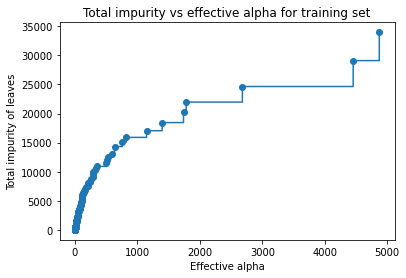

In [33]:
# Create a new regression tree object
clf_pruning = DecisionTreeRegressor()
# Create a path for all values of alpha, from zero to largest, which leads to the smallest tree.
path = clf_pruning.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
# Plot increase in tree impurity with alpha
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("Effective alpha")
ax.set_ylabel("Total impurity of leaves")
ax.set_title("Total impurity vs effective alpha for training set")
plt.show()

In order to find the optimal value for $\alpha$, which will decrease tree complexity to a point where the model does not over-fit the data while maintaining the highest accuracy, we compute the training and testing scores for all values of $\alpha$.

In [34]:
# Create a regression tree for each element of the cost complexity path
clfs = []
count = 1
for ccp_alpha in ccp_alphas:
    clf_p = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf_p.fit(X_train, y_train)
    clfs.append(clf_p)
    count+=1
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
  clfs[-1].tree_.node_count, ccp_alphas[-1]))

# Drop the tree with maximum alpha, which is a trivial tree with only one leaf  
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

Number of nodes in the last tree is: 3 with ccp_alpha: 25723.16114072535


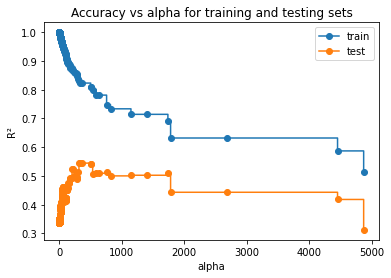

In [35]:
# Compute accuracy (MSE or R2) for each value of alpha for both training and testing data
# Select "R²" or "MSE" in the following line

metric = "R²" # "R²" or "MSE"

if metric == "R²":
  train_scores = [clf.score(X_train, y_train) for clf in clfs]
  test_scores = [clf.score(X_test_m, y_test_m) for clf in clfs]
elif metric == "MSE":
  train_scores = [mean_squared_error(y_train, clf.predict(X_train)) for clf in clfs]
  test_scores = [mean_squared_error(y_test_m, clf.predict(X_test_m)) for clf in clfs]
else:
  print("Error: metric not recognized. Please select \"R²\" or \"MSE\".")

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel(metric)
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
    drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
    drawstyle="steps-post")
ax.legend()
plt.show()

We can magnify the plot to see the point where testing accuracy is highest.

Best R²: 54.54 %
Corresponding alpha: 314.85 at index 690 out of 707 indices.


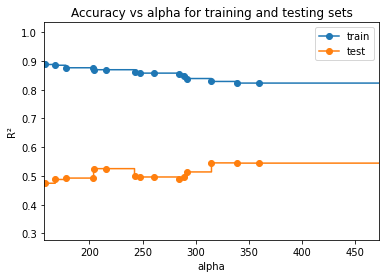

In [36]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel(metric)
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
    drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
    drawstyle="steps-post")

# Find best alpha that optimizes testing performance
best_alpha = -1
index = -1
if metric == "MSE":
  max_score = 100000
  for i in range(len(test_scores)):
    if test_scores[i] < max_score:
      max_score = test_scores[i]
      best_alpha = ccp_alphas[i]
      index = i
  print("Best MSE: %.2f Watts" % max_score)
  print("Corresponding alpha: %.2f at index %d out of %d indices." % (best_alpha, index, len(test_scores)))
else:
  max_score = -1
  for i in range(len(test_scores)):
    if test_scores[i] > max_score:
      max_score = test_scores[i]
      best_alpha = ccp_alphas[i]
      index = i  
  print("Best R²: %.2f %%" % (max_score*100))
  print("Corresponding alpha: %.2f at index %d out of %d indices." % (best_alpha, index, len(test_scores)))

ax.legend()
ax.set_xlim(max(0, best_alpha*0.5), min(ccp_alphas[-1], best_alpha*1.5))
#ax.set_ylim(0.5, 1.1)
plt.show()

Below, a comparison of the prediction of a fully-grown tree ($\alpha = 0$), a tree with the optimal $\alpha$ (the value that yields the best testing accuracy), and the maximum value for alpha, which gives a tree with two splits.

In [37]:
prediction_alphas = [clf.predict(X_test_m) for clf in [clfs[0], clfs[index], clfs[-1]]]

In [38]:
print("Maximum depth of unpruned regression tree: ", clfs[0].tree_.max_depth)
print("Number of leaves of unpruned regression tree: ", clfs[0].get_n_leaves())
print("Maximum depth of pruned regression tree: ", clfs[index].tree_.max_depth)
print("Number of leaves of pruned regression tree: ", clfs[index].get_n_leaves())
print("Maximum depth of smallest regression tree: ", clfs[-1].tree_.max_depth)
print("Number of leaves of smallest regression tree: ", clfs[-1].get_n_leaves())

Maximum depth of unpruned regression tree:  20
Number of leaves of unpruned regression tree:  720
Maximum depth of pruned regression tree:  6
Number of leaves of pruned regression tree:  19
Maximum depth of smallest regression tree:  2
Number of leaves of smallest regression tree:  3


Here is a plot of the training predictions for the pruned tree:

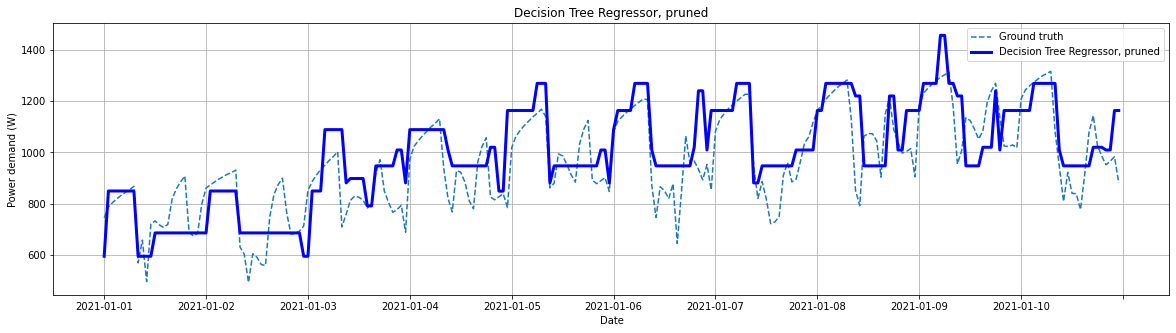

In [39]:
# Plot prediction results
singlePredPlot(y_test_m, prediction_alphas[1], "Decision Tree Regressor, pruned", testxlabels, step)

Below, a comparison of predictions using the fully-grown tree, optimally pruned tree, and the smallest tree with 3 splits, using the testing data.

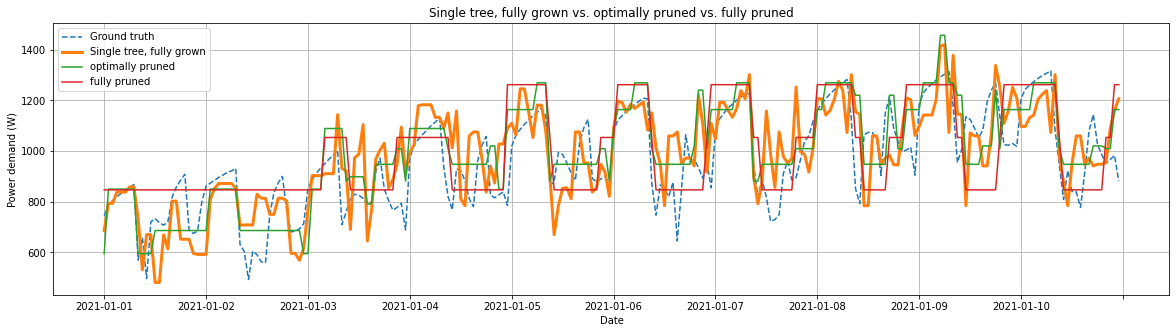

In [40]:
singlePredPlot(y_test_m, [prediction_alphas[0], prediction_alphas[1], prediction_alphas[2]], ["Single tree, fully grown", "optimally pruned", "fully pruned"], testxlabels, step)

This is a visual representation of the pruned tree:

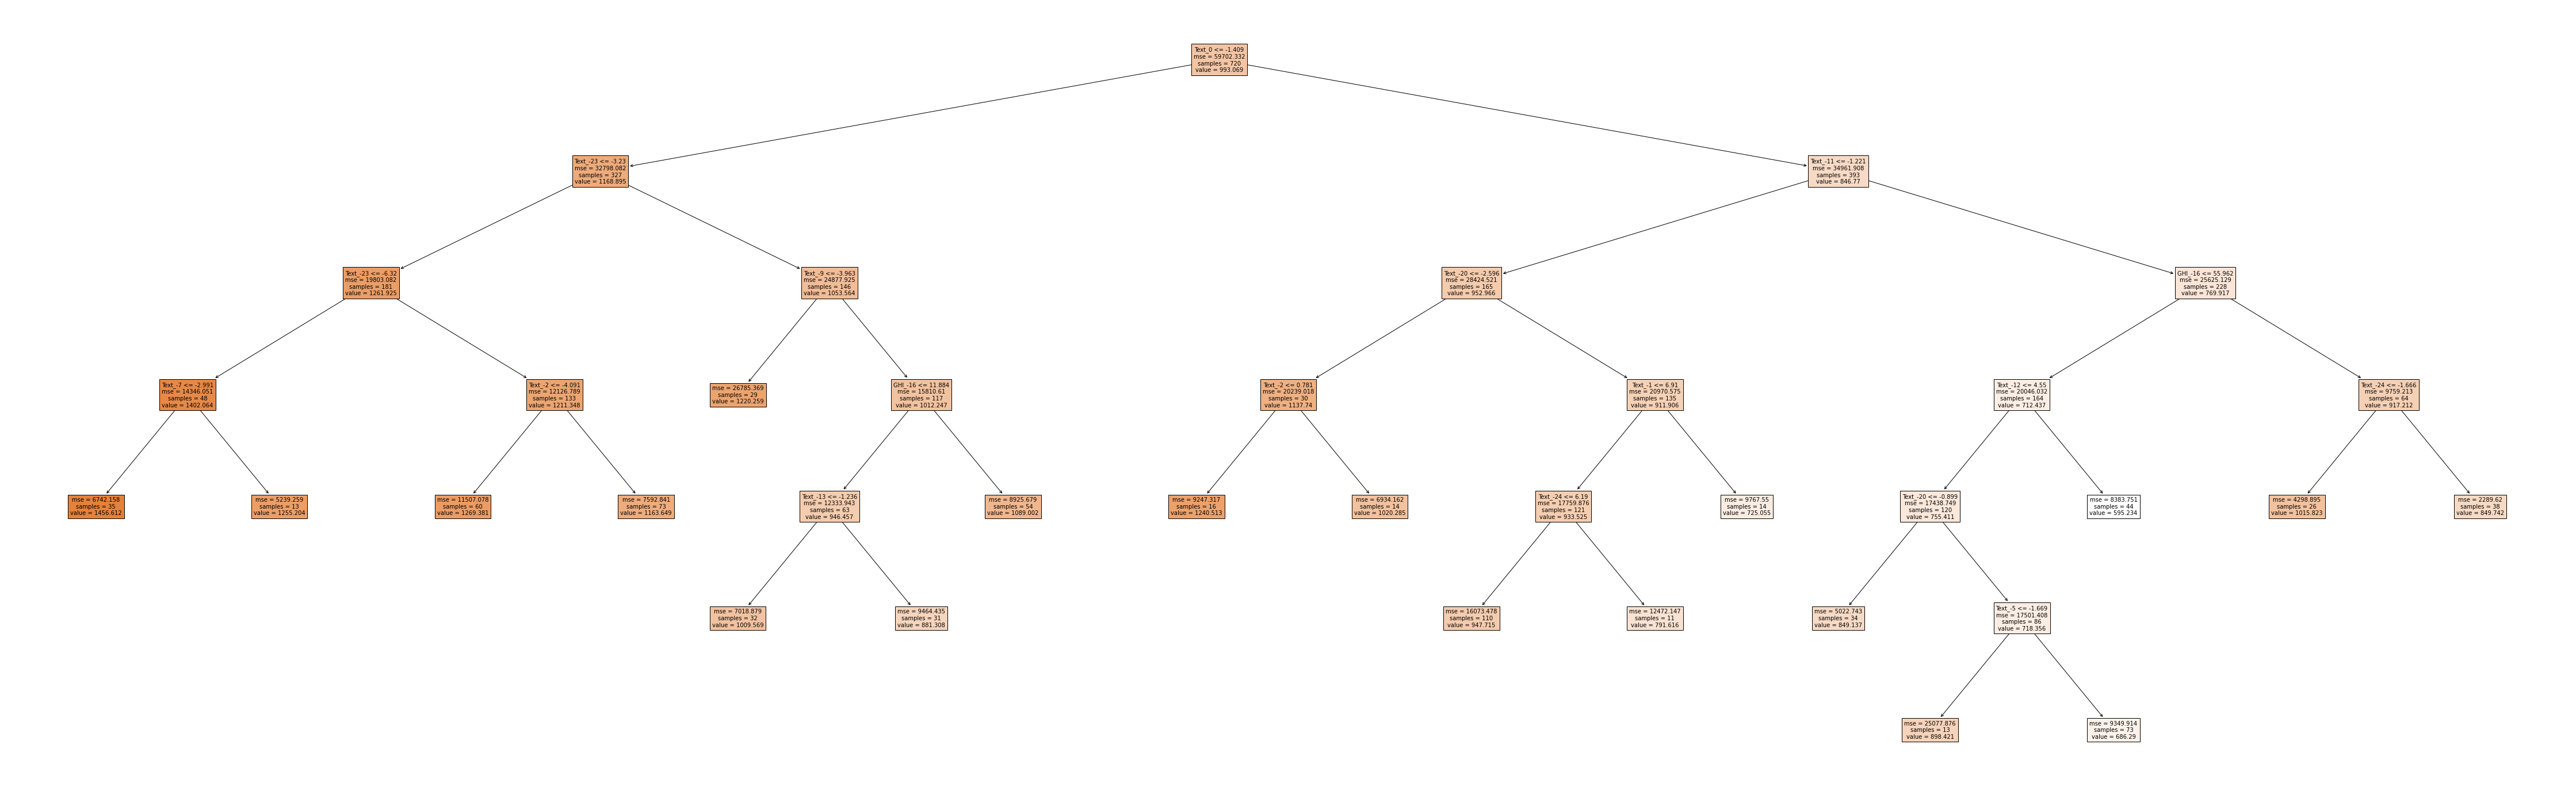

In [41]:
plt.figure(figsize=(80, 25))
tree.plot_tree(clfs[index], filled=True, fontsize=10, feature_names=X_train.columns)
plt.show()

**Predictor Importance**

Not all predictors provide meaningful information when extracting the regression tree. Here, we assess the importance of each predictor on the model quality, using permutation importance. Read more about it [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html?highlight=permutation%20importance). The plot represents the mean accuracy decrease when removing each predictor from a forest of fully-grown trees. This plot informs us about the relative importance of each predictor. For example, we can say that the current external air temperature is the most important predictor when evaluating the system's heating and cooling load.

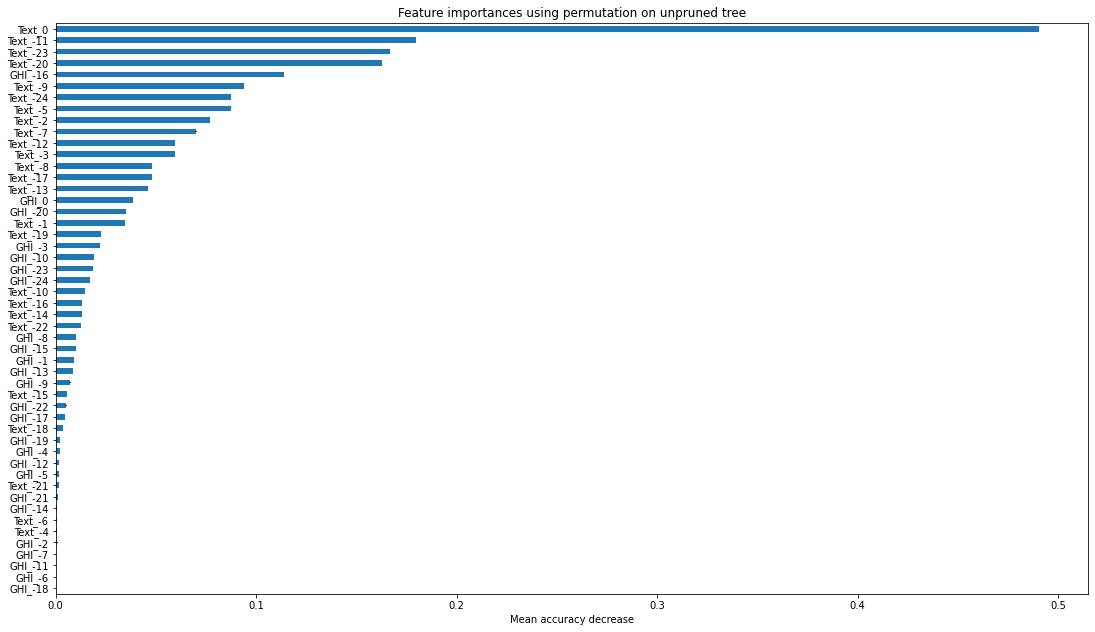

In [42]:
# Extract all feature names
feature_names = [str(name) for name in inp.columns]
result = permutation_importance(clfs[0], X_train, y_train, n_repeats=100, random_state=0)
feature_names_pos = []
# Extract mean feature importance, limited to nonzero positive values.
for i in range(len(feature_names)):
  if result.importances_mean[i] > 0:
    feature_names_pos.append(feature_names[i])
forest_importances = pd.Series([importance for importance in result.importances_mean if importance > 0], index=feature_names_pos)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
forest_importances.sort_values().plot.barh(yerr=[result.importances_std[i] for i in range(len(result.importances_std)) if result.importances_mean[i] >0], ax=ax)
ax.set_title("Feature importances using permutation on unpruned tree")
ax.set_xlabel("Mean accuracy decrease")
plt.show()

If we limit the cost complexity parameter $\alpha$ to the value that we found after pruning, here is the predictor importance plot:

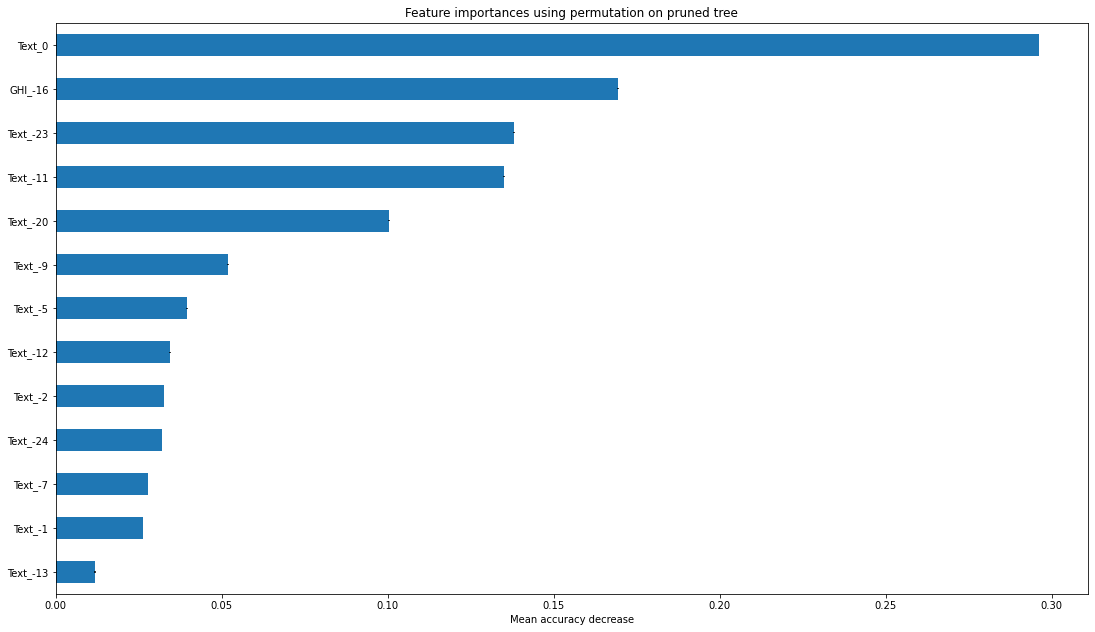

In [43]:
# Extract all feature names
feature_names = [str(name) for name in inp.columns]
result = permutation_importance(clfs[index], X_train, y_train, n_repeats=100, random_state=0)
feature_names_pos = []
# Extract mean feature importance, limited to nonzero positive values.
for i in range(len(feature_names)):
  if result.importances_mean[i] > 0:
    feature_names_pos.append(feature_names[i])
forest_importances = pd.Series([importance for importance in result.importances_mean if importance > 0], index=feature_names_pos)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
forest_importances.sort_values().plot.barh(yerr=[result.importances_std[i] for i in range(len(result.importances_std)) if result.importances_mean[i] >0], ax=ax)
ax.set_title("Feature importances using permutation on pruned tree")
ax.set_xlabel("Mean accuracy decrease")
plt.show()

We compare the predictors retained by the tree pruning process to those that have non-zero coefficients after the Lasso regression:

In [44]:
matching = []
nomatch = []
lasso_coefs = []
for key, value in coefficients_lassoreg.items():
  if value != 0.0:
    lasso_coefs.append(key)

print('Predictors identified in both methods:')
print('\nPredictor\tLasso coeff.\tPruning importance\n')
intersection = list(set(lasso_coefs) & set(feature_names_pos))
for item in intersection:
  print('%s  \t%.3f\t\t%.3f' % (item, coefficients_lassoreg[item], forest_importances[item]))

print('\nPredictors retained by Lasso, but not by the tree pruning process:')
lasso_notpruned = [item for item in lasso_coefs if item not in feature_names_pos]
for item in lasso_notpruned:
  print(item)

print('Predictors retained by the tree pruning process, but not Lasso:')
pruned_notlasso = [item for item in feature_names_pos if item not in lasso_coefs]
for item in pruned_notlasso:
  print(item)

Predictors identified in both methods:

Predictor	Lasso coeff.	Pruning importance

Text_-24  	-20.463		0.032
Text_-13  	-1.771		0.012
GHI_-16  	-0.063		0.169
Text_-9  	-8.242		0.052
Text_0  	-13.537		0.296

Predictors retained by Lasso, but not by the tree pruning process:
GHI_0
GHI_-1
GHI_-2
Text_-3
GHI_-3
GHI_-4
GHI_-5
GHI_-6
GHI_-7
GHI_-8
GHI_-9
Text_-10
GHI_-10
GHI_-11
GHI_-12
GHI_-14
GHI_-15
GHI_-17
GHI_-18
GHI_-19
GHI_-20
GHI_-21
GHI_-22
GHI_-23
GHI_-24
Predictors retained by the tree pruning process, but not Lasso:
Text_-1
Text_-2
Text_-5
Text_-7
Text_-11
Text_-12
Text_-20
Text_-23


We compute the 1-day predictions, 10 times, at midnight each day for 10 days. We compute the CV(RMSE) on this 10-day prediction.

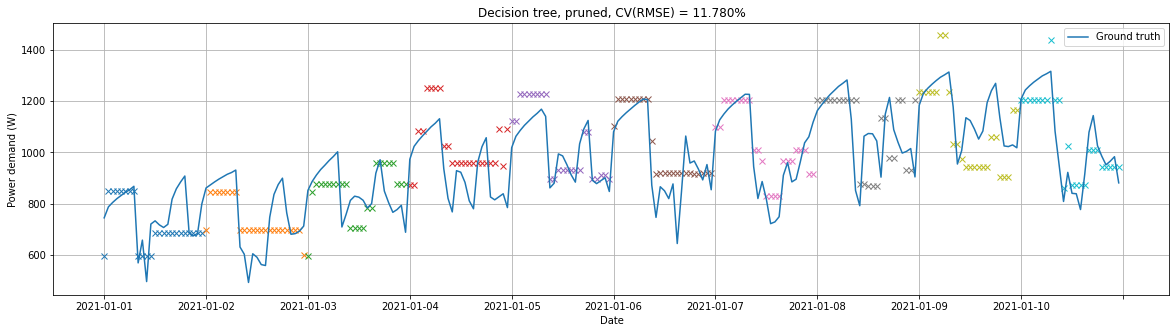

In [45]:
final_results = predictWithRetraining(method = clfs[index], name = "Decision tree, pruned")

## **Approach 2: Tree Bagging**

The decision trees discussed thus far suffer from high variance. This means that if we split the training data into two parts at random, and fit a decision tree to both halves, the results that we get could be quite different. In contrast, a procedure with low variance will yield similar results if applied repeatedly to distinct data sets; linear regression tends to have low variance if the ratio of $n$ samples to $p$ predictors is moderately large. Bootstrap aggregation, or bagging, is a general-purpose procedure for reducing the variance of a statistical learning method; we introduce it here because it is particularly useful and frequently used in the context of decision trees.

Recall that given a set of $n$ independent observations $Z_1,\ldots,Z_n$, each with variance $\sigma^2$, the variance of the mean $\bar{Z}$ of the observations is given by $\sigma^2/n$. In other words, averaging a set of observations reduces variance. Hence a natural way to reduce the variance and hence increase the prediction accuracy of a statistical learning method is to take many training sets from the population, build a separate prediction model using each training set, and average the resulting predictions. In other words, we could calculate $\hat{f}^1(x), \hat{f}^2(x),\ldots,\hat{f}^B(x)$ using $B$ separate training sets, and average them in order to obtain a single low-variance statistical learning model, given by

\begin{equation}
\hat{f}_{avg}(x) = \frac{1}{B} \sum_{b=1}^B \hat{f}^b(x)
\end{equation}

Of course, this is not practical because we generally do not have access to multiple training sets. Instead, we can bootstrap, by taking repeated samples from the (single) training data set. In this approach we generate $B$ different bootstrapped training data sets. We then train our method on the $b$-th bootstrapped training set in order to get $\hat{f}^{*b}(x)$, and finally average all the predictions, to obtain

\begin{equation}
\hat{f}_{bag}(x) = \frac{1}{B} \sum_{b=1}^B \hat{f}^{*b}(x)
\end{equation}

This is called bagging, short for bootstrap aggregation.

While bagging can improve predictions for many regression methods,
it is particularly useful for decision trees. To apply bagging to regression trees, we simply construct $B$ regression trees using $B$ bootstrapped training sets, and average the resulting predictions. *These trees are grown deep, and are not pruned.* Hence each individual tree has high variance, but low bias. Averaging these $B$ trees reduces the variance. Bagging has been demonstrated to give impressive improvements in accuracy by combining together hundreds or even thousands of trees into a single procedure.

The number of trees $B$ is not a critical parameter with bagging; using a very large value of B will not lead to overfitting. In practice we use a value of B sufficiently large that the error has settled down.

The presented approach uses the Scikit's `BaggingRegressor` method.

**Basic bagging:**

In [46]:
# Create B = 100 bagged trees
bagged = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100).fit(X_train, y_train)
prediction_bagging = bagged.predict(X_test_m)

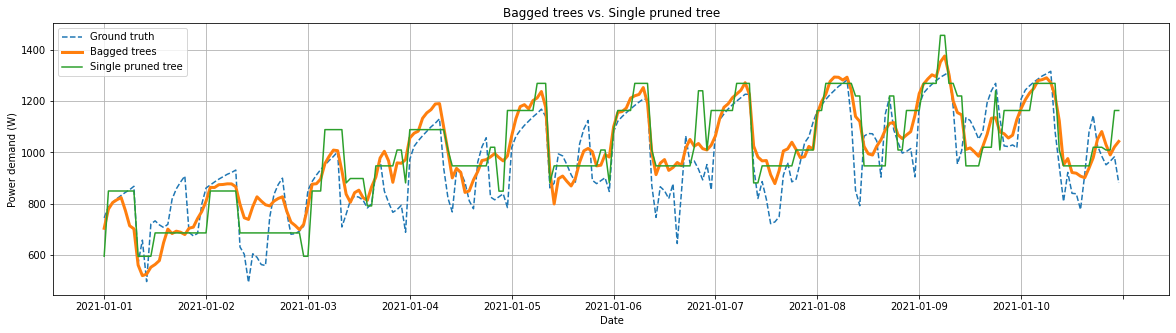

In [47]:
singlePredPlot(y_test_m, [prediction_bagging, prediction_alphas[1]], ["Bagged trees", "Single pruned tree"], testxlabels, step)

In [48]:
print("Linear regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lreg)*100), mean_squared_error(y_test_m, prediction_lreg)))
print("Lasso regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lassoreg)*100), mean_squared_error(y_test_m, prediction_lassoreg)))
print("Pruned single tree: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_alphas[1])*100), mean_squared_error(y_test_m, prediction_unpruned)))
print("Bagging: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_bagging)*100), mean_squared_error(y_test_m, prediction_bagging)))

Linear regression: 	 R² = 68.03 % and MSE = 10815.79 Watts
Lasso regression: 	 R² = 68.88 % and MSE = 10530.00 Watts
Pruned single tree: 	 R² = 54.54 % and MSE = 22286.50 Watts
Bagging: 	 	 R² = 68.69 % and MSE = 10595.29 Watts


On the current dataset, tree bagging provides a better estimator than a single pruned tree.

And now predicting 10 days consecutively one after the other. 

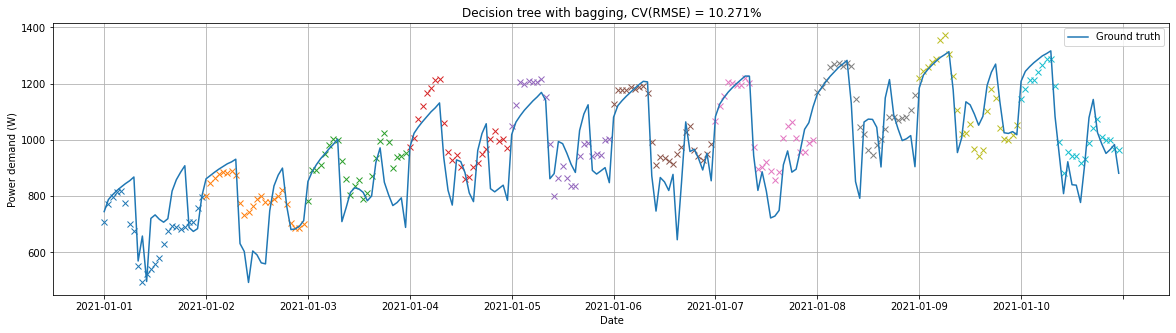

In [49]:
bagging_results = predictWithRetraining(method = bagged, name = "Decision tree with bagging")

**Random Patches**

Random patches are similar to bagging, except that both the training samples **and** subsets of the predictors are randomly picked for each subtree before combining the subtrees. 

Reference: G. Louppe and P. Geurts, “Ensembles on Random Patches”, Machine Learning and Knowledge Discovery in Databases, 346-361, 2012.

In [50]:
random_patches = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100, bootstrap_features=True).fit(X_train, y_train)
prediction_random_patches = random_patches.predict(X_test_m)

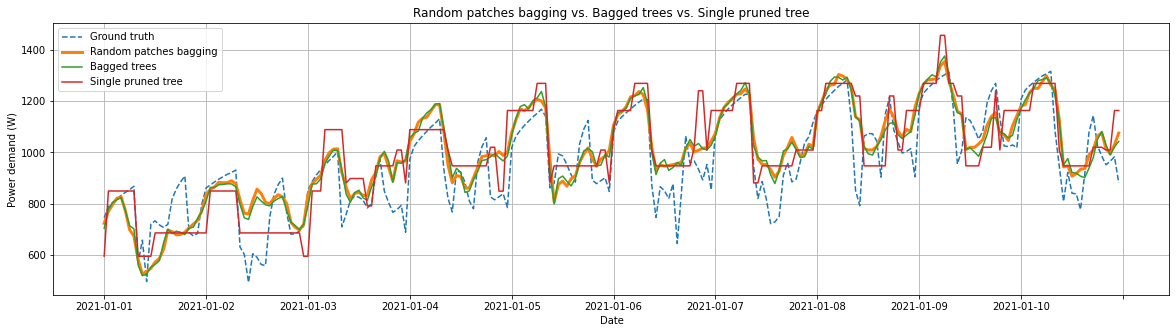

In [51]:
singlePredPlot(y_test_m, [prediction_random_patches, prediction_bagging, prediction_alphas[1]], ["Random patches bagging", "Bagged trees", "Single pruned tree"], testxlabels, step)

In [52]:
print("Linear regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lreg)*100), mean_squared_error(y_test_m, prediction_lreg)))
print("Lasso regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lassoreg)*100), mean_squared_error(y_test_m, prediction_lassoreg)))
print("Pruned single tree: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_alphas[1])*100), mean_squared_error(y_test_m, prediction_unpruned)))
print("Bagging: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_bagging)*100), mean_squared_error(y_test_m, prediction_bagging)))
print("Random patches: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_patches)*100), mean_squared_error(y_test_m, prediction_random_patches)))

Linear regression: 	 R² = 68.03 % and MSE = 10815.79 Watts
Lasso regression: 	 R² = 68.88 % and MSE = 10530.00 Watts
Pruned single tree: 	 R² = 54.54 % and MSE = 22286.50 Watts
Bagging: 	 	 R² = 68.69 % and MSE = 10595.29 Watts
Random patches: 	 R² = 67.42 % and MSE = 11024.13 Watts


The metrics show that random patches, in our case, is superior to bagging for case 6.

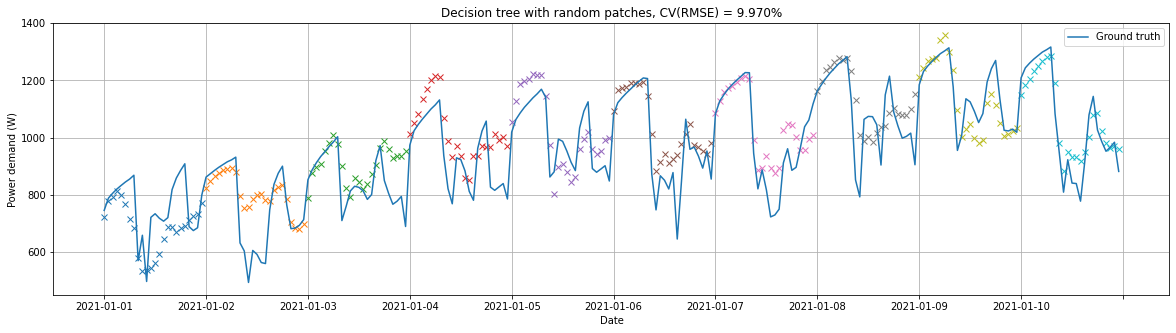

In [53]:
patches_results = predictWithRetraining(method = random_patches, name = "Decision tree with random patches")

## **Approach 3: Random Forests**

Random forests provide an improvement over bagged trees by way of a small tweak that decorrelates the trees. As in bagging, we build a number of decision trees on bootstrapped training samples. But when building these decision trees, each time a split in a tree is considered, a random sample of $m$ predictors is chosen as split candidates from the full set of $p$ predictors. The split is allowed to use only one of those $m$ predictors. A fresh sample of $m$ predictors is taken at each split, and typically we choose $m \approx \sqrt{p}$, i.e., the number of predictors considered at each split is approximately equal to the square root of the total number of predictors.

In [54]:
maxFeatures = round(math.sqrt(len(X_train.columns)))
print(maxFeatures)
rndForest = RandomForestRegressor(n_estimators=100, max_features = maxFeatures) 
rndForest.fit(X_train, y_train)
prediction_random_forest = rndForest.predict(X_test_m)

7


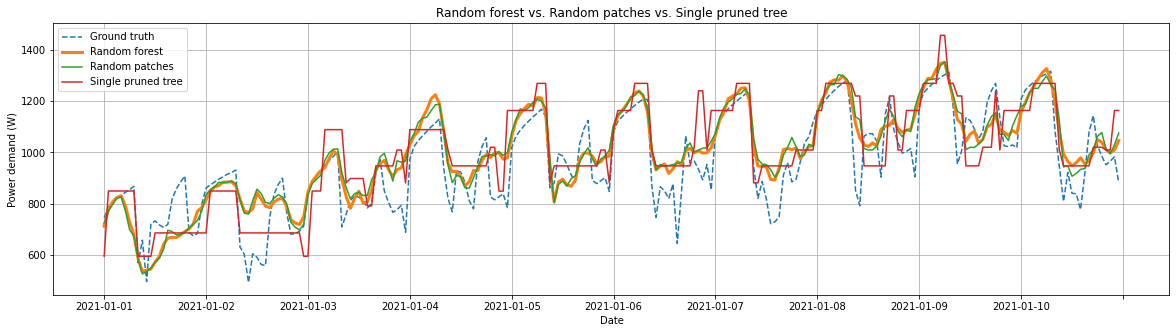

In [55]:
singlePredPlot(y_test_m, [prediction_random_forest, prediction_random_patches, prediction_alphas[1]], ["Random forest", "Random patches", "Single pruned tree"], testxlabels, step)

In [56]:
print("Linear regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lreg)*100), mean_squared_error(y_test_m, prediction_lreg)))
print("Lasso regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lassoreg)*100), mean_squared_error(y_test_m, prediction_lassoreg)))
print("Pruned single tree: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_alphas[1])*100), mean_squared_error(y_test_m, prediction_unpruned)))
print("Bagging: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_bagging)*100), mean_squared_error(y_test_m, prediction_bagging)))
print("Random patches: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_patches)*100), mean_squared_error(y_test_m, prediction_random_patches)))
print("Random forest: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_forest)*100), mean_squared_error(y_test_m, prediction_random_forest)))

Linear regression: 	 R² = 68.03 % and MSE = 10815.79 Watts
Lasso regression: 	 R² = 68.88 % and MSE = 10530.00 Watts
Pruned single tree: 	 R² = 54.54 % and MSE = 22286.50 Watts
Bagging: 	 	 R² = 68.69 % and MSE = 10595.29 Watts
Random patches: 	 R² = 67.42 % and MSE = 11024.13 Watts
Random forest: 	 	 R² = 70.13 % and MSE = 10106.99 Watts


In our case, the random forest is significantly better than random patches.

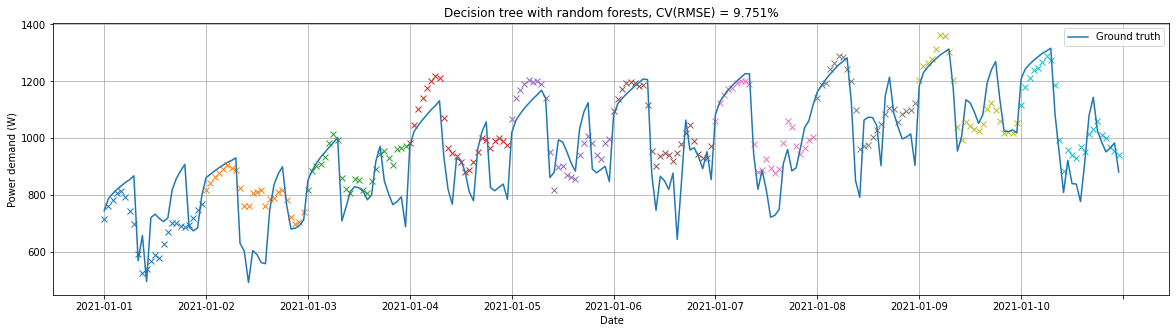

In [57]:
rnd_forest_results = predictWithRetraining(method = rndForest, name = "Decision tree with random forests")

## **Approach 4: Boosting**

We now discuss boosting, yet another approach for improving the predictions resulting from a decision tree. Like bagging, boosting is a general approach that can be applied to many statistical learning methods for regression or classification. Here we restrict our discussion of boosting to the context of decision trees.

Recall that bagging involves creating multiple copies of the original training data set using the bootstrap, fitting a separate decision tree to each copy, and then combining all of the trees in order to create a single predictive model. Notably, each tree is built on a bootstrap data set, independent of the other trees. Boosting works in a similar way, except that the trees are grown sequentially: each tree is grown using information from previously grown trees. Boosting does not involve bootstrap sampling; instead each tree is fit on a modified version of the original data set.

Like bagging, boosting involves combining a large number of decision trees, $\hat{f}^1, \ldots ,\hat{f}^B$. Unlike fitting a single large decision tree to the data, which amounts to fitting the data hard and potentially overfitting, the boosting approach instead learns slowly. Given the current model, we fit a decision tree to the residuals from the model. That is, we fit a tree using the current residuals, rather than the outcome $Y$, as the response. We then add this new decision tree into the fitted function in order to update the residuals. Each of these trees can be rather small, with just a few terminal nodes, determined by the parameter $d$ in the algorithm. By fitting small trees to the residuals, we slowly improve $\hat{f}$ in areas where it does not perform well. The shrinkage parameter $\lambda$ slows the process down even further, allowing more and different shaped trees to attack the residuals. In general, statistical learning approaches that learn slowly tend to perform well. Note that in boosting, unlike in bagging, the construction of each tree depends strongly on the trees that have already been grown.

Boosting has three tuning parameters:
1. The number of trees $B$. Unlike bagging and random forests, boosting can overfit if $B$ is too large, although this overfitting tends to occur slowly if at all. 
2. The shrinkage parameter $\lambda$, a small positive number. This controls the rate at which boosting learns. Typical values are 0.01 or 0.001, and the right choice can depend on the problem. Very small $\lambda$ can require using a very large value of $B$ in order to achieve good performance.
3. The number $d$ of splits in each tree, which controls the complexity of the boosted ensemble. Often $d = 1$ works well, in which case each tree is a stump, consisting of a single split. In this case, the boosted ensemble is fitting an additive model, since each term involves only a single variable. More generally $d$ is the interaction depth, and controls the interaction order of the boosted model, since $d$ splits can involve at most $d$ variables.



In [58]:
boost = AdaBoostRegressor(tree.DecisionTreeRegressor(max_depth = 2), learning_rate = 0.01, n_estimators=5000)  
boost.fit(X_train, y_train)
prediction_boost = boost.predict(X_test_m)

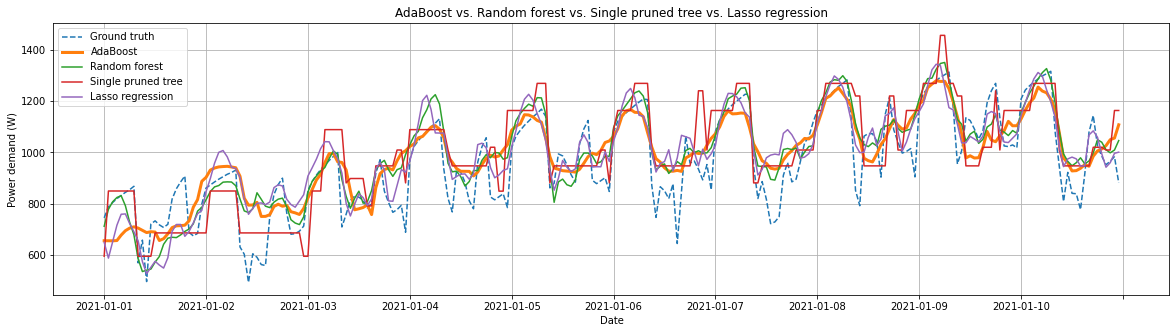

In [59]:
singlePredPlot(y_test_m, [prediction_boost, prediction_random_forest, prediction_alphas[1], prediction_lassoreg], ["AdaBoost", "Random forest", "Single pruned tree", "Lasso regression"], testxlabels, step)

In [60]:
print("Linear regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lreg)*100), mean_squared_error(y_test_m, prediction_lreg)))
print("Lasso regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lassoreg)*100), mean_squared_error(y_test_m, prediction_lassoreg)))
print("Pruned single tree: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_alphas[1])*100), mean_squared_error(y_test_m, prediction_unpruned)))
print("Bagging: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_bagging)*100), mean_squared_error(y_test_m, prediction_bagging)))
print("Random patches: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_patches)*100), mean_squared_error(y_test_m, prediction_random_patches)))
print("Random forest: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_forest)*100), mean_squared_error(y_test_m, prediction_random_forest)))
print("Boosting: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_boost)*100), mean_squared_error(y_test_m, prediction_boost)))

Linear regression: 	 R² = 68.03 % and MSE = 10815.79 Watts
Lasso regression: 	 R² = 68.88 % and MSE = 10530.00 Watts
Pruned single tree: 	 R² = 54.54 % and MSE = 22286.50 Watts
Bagging: 	 	 R² = 68.69 % and MSE = 10595.29 Watts
Random patches: 	 R² = 67.42 % and MSE = 11024.13 Watts
Random forest: 	 	 R² = 70.13 % and MSE = 10106.99 Watts
Boosting: 	 	 R² = 63.16 % and MSE = 12465.14 Watts


Boosting does not perform as well as bagging, random patches, and a random forests for this case. 

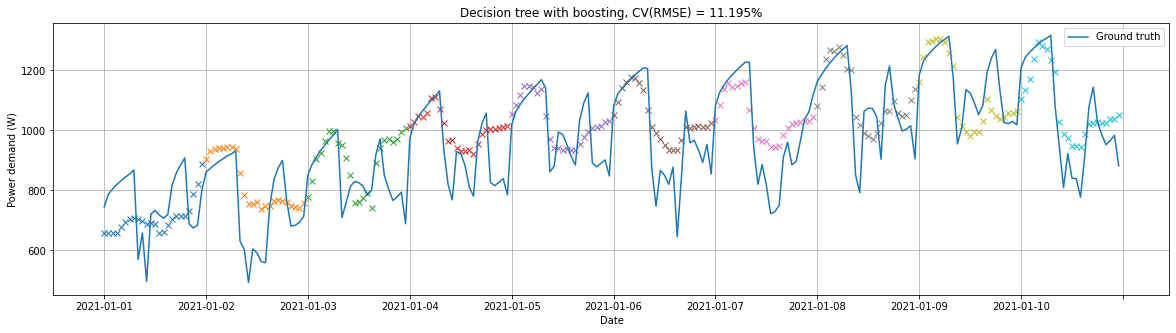

In [61]:
boost_results = predictWithRetraining(method = boost, name = "Decision tree with boosting")

#**Support Vector Regression**

The support vector algorithm is a class of nonlinear generalization algorithms developed in the early 1960s. Support vectors are created by minimizing the error between the proposed hyperplane and the training data. Once minimized, the datapoints that are used to define the "tube" are the support vectors. If a support vector is removed, then the shape and performance of the model can change significantly.

Support vector algorithms use kernel functions to select the observed data that are included in the minimization equation. The most common kernels are linear, polynomial, sigmoid, and radial basis functions. The radial basis function (RBF) (equation below) was used in this analysis because the RBF nonlinearly maps datapoints to a higher dimension, which allows for relationships between the covariates to also be nonlinear. The parameter $\gamma$ is recommended to be set at $1/n$; however, $\gamma$ should still be included in the hyperparameter tuning.
	
\begin{equation}
k(x_i, x_j) = \exp(-\gamma||x_i - x_j||^2)
\end{equation}
	
The build times for support vectors can be quite long due to the computational requirements (memory and CPU) to calculate and store the dot product matrix. In 2004, it was suggested that after 3,000 samples the user must use another approach to compute the support vectors.

Support vectors have a few training hyperparameters that need to be evaluated, which are:
	
* C: the penalty parameter of the error term, defaults to 1

* $\gamma$: the parameter in the RBF equation, defaults to $1/n$

* $\epsilon$: range of the penalty-free "tube" defaults to 0.1.
	
In the case of the hyperparameters and grid search, the user specifies ranges of model parameters to evaluate. The hyperparameters of $C$, $\gamma$, and $\epsilon$ were chosen to be order of magnitudes in the grid search. More advanced methods are available to determine optimal hyperparameters such as using evolutionary strategies with grid searches to speed up the processing time.

For more information, see this [paper](https://www.tandfonline.com/doi/abs/10.1080/19401493.2021.1884291?casa_token=Zbucz9W-JWEAAAAA:Ef8wlPEYreyABab1_VAj4vAtVSqeufR6cDCcg6k_5B6QIajYzAZBwq9hMSob0UjovNZG7-p4-6Ru): Long, N., Almajed, F., von Rhein, J., & Henze, G. (2021). Development of a metamodelling framework for building energy models with application to fifth-generation district heating and cooling networks. Journal of Building Performance Simulation, 14(2), 203-225.




In [62]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

svr = GridSearchCV(SVR(kernel='rbf', epsilon=0.1),
                   param_grid={"C": [1e-1, 1e0, 1e1, 1e2, 1e3],
                               "gamma": [0.25, 0.1, 0.01],
                               "epsilon": [0.1, 0.25, 0.5]
                               })

SVRreg = make_pipeline(StandardScaler(), svr)
SVRreg.fit(X_train, y_train)
prediction_svr = SVRreg.predict(X_test_m)

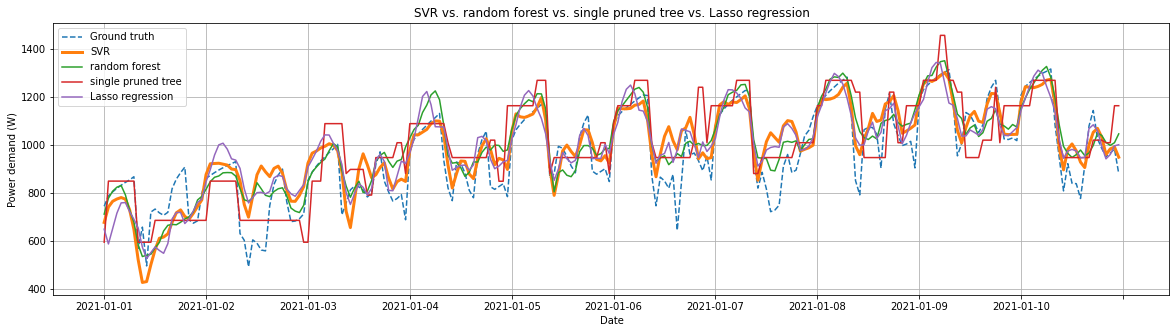

In [63]:
singlePredPlot(y_test_m, [prediction_svr, prediction_random_forest, prediction_alphas[1], prediction_lassoreg], ["SVR", "random forest", "single pruned tree", "Lasso regression"], testxlabels, step)

In [64]:
print("Linear regression: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lreg)*100), mean_squared_error(y_test_m, prediction_lreg)))
print("Lasso regression: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lassoreg)*100), mean_squared_error(y_test_m, prediction_lassoreg)))
print("Pruned single tree: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_alphas[1])*100), mean_squared_error(y_test_m, prediction_unpruned)))
print("Bagging: \t \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_bagging)*100), mean_squared_error(y_test_m, prediction_bagging)))
print("Random patches: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_patches)*100), mean_squared_error(y_test_m, prediction_random_patches)))
print("Random forest: \t \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_forest)*100), mean_squared_error(y_test_m, prediction_random_forest)))
print("Boosting: \t \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_boost)*100), mean_squared_error(y_test_m, prediction_boost)))
print("Support vector regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_svr)*100), mean_squared_error(y_test_m, prediction_svr)))

Linear regression: 	 	 R² = 68.03 % and MSE = 10815.79 Watts
Lasso regression: 	 	 R² = 68.88 % and MSE = 10530.00 Watts
Pruned single tree: 	 	 R² = 54.54 % and MSE = 22286.50 Watts
Bagging: 	 	 	 R² = 68.69 % and MSE = 10595.29 Watts
Random patches: 	 	 R² = 67.42 % and MSE = 11024.13 Watts
Random forest: 	 	 	 R² = 70.13 % and MSE = 10106.99 Watts
Boosting: 	 	 	 R² = 63.16 % and MSE = 12465.14 Watts
Support vector regression: 	 R² = 70.32 % and MSE = 10041.89 Watts


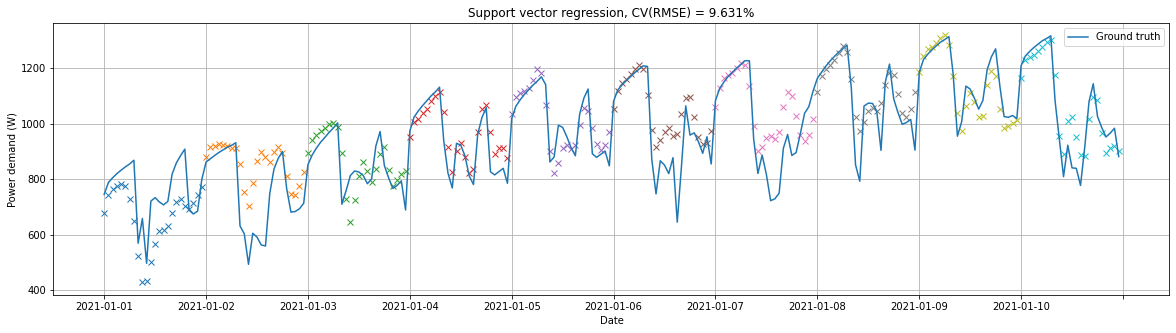

In [65]:
SVRreg_results = predictWithRetraining(method = SVRreg, name = "Support vector regression")

## **Kernel Ridge Regression**

Kernel ridge regression (KRR) is a special case of support vector regression and thus also a nonlinear form of regression with a regularization term to prevent overfitting to fit the unknown data producing function $y=f(\mathbf{x})+w$, where $w$ is a noise term.

The general form of KRR is
\begin{equation}
f^{\text{KRR}}(\mathbf{x}) = \sum_{i=1}^n \theta_i k(\mathbf{x},\mathbf{x}_i)
\end{equation}
where $\theta_i$ are the weights and $k$ is the kernel, which is a measure between the similarity between features. Here, we use the Gaussian or RBF kernel function
\begin{equation}
k(\mathbf{x},\mathbf{x}') = \exp(-\frac{||x_i - x_j||^2}{2L^2})
\end{equation}

The hyperparameter $L$ is the length scale of the Gaussian kernel function, which controls the degree of correlation between training points. The weights $\theta_i$ are obtained through the minimization of the cost function $J$
\begin{equation}
\hat{\theta} = \arg\min_{\theta} J(\theta)
\end{equation}
\begin{equation}
J(\theta) = \sum_{i=1}^n (y_i - \sum_{j=1}^n \theta_j k(\mathbf{x},\mathbf{x}_i))^2 + \alpha \theta^T K^T \theta
\end{equation}
where $\theta = (\theta_1, \ldots, \theta_n)^T$ and $K$ is the kernel matrix with elements $K_{ij} = k(\mathbf{x}_i, \mathbf{x}_j)$ and the second term on the right hand side accomplishes the regularization with weight $\alpha$. With known $\mathbf{y} = (y_1, \ldots, y_n)^T$, this can be rewritten as
\begin{equation}
J(\theta) = (\mathbf{y}-K\theta)^T(\mathbf{y}-K\theta)+\alpha \theta^T K^T \theta
\end{equation}

Minimizing $J(\theta)$ with respect $\theta$ leads to 
\begin{equation}
(K^TK+\alpha K^T) \hat{\theta} = K^T \mathbf{y}
\end{equation}
or
\begin{equation}
(K+\alpha I) \hat{\theta} = \mathbf{y}
\end{equation}
where $I$ is the identity matrix and where $K^T = K$ has been assumed to be invertible (true for the Gaussian kernel function). 

The two hyperparameters $\alpha$ and $L$ must be inferred from the data. $L$ can be viewed as the characteristic length scale of the problem being learned (the scale on which changes of $f$ take place), as discernible from the data (and thus dependent on the number of training samples). $\alpha$ controls the leeway the model has to fit the training points. For small $\alpha$, the model has to fit the training points exactly, whereas for larger $\alpha$ some deviation is allowed. Larger values of $\alpha$ therefore cause the model to be smoother and vary less, i.e., are less prone to overfitting.

Once $\hat{\theta}$ has been obtained, given an unknown vector $\mathbf{x}$, the corresponding prediction value of the dependent variable $\hat{y}$ is given by
\begin{equation}
\hat{y} = \sum_{i=1}^n \hat{\theta}_i k(\mathbf{x}, \mathbf{x}_i) = \hat{\theta}^T \mathbf{k}(\mathbf{x})
\end{equation}
where $\mathbf{k}(\mathbf{x}) = [k(\mathbf{x},\mathbf{x}_1), \ldots k(\mathbf{x},\mathbf{x}_n)]^T$. 

With $(K+\alpha I) \hat{\theta} = \mathbf{y}$, we finally obtain
\begin{equation}
\hat{y}(\mathbf{x}) = \mathbf{y}^T(K+\alpha I)^{-1} \mathbf{k}(\mathbf{x}).
\end{equation}





In [66]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF

# Fit kernel ridge with parameter selection based on 5-fold cross validation
param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],
              "kernel": [RBF(lengthscale)
                          for lengthscale in np.logspace(-5, 5, 20)]}
KRRreg = GridSearchCV(KernelRidge(), param_grid = param_grid)
KRRreg.fit(X_train, y_train)
prediction_krr = KRRreg.predict(X_test_m)

Time for KRR fitting: 27.669


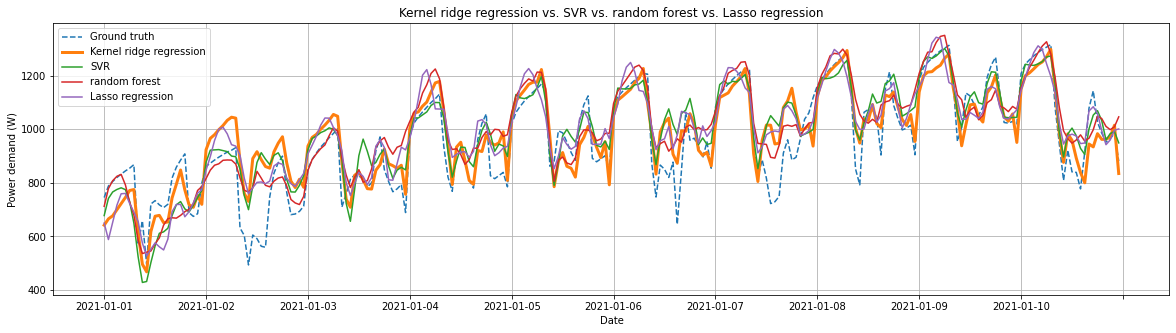

In [67]:
singlePredPlot(y_test_m, [prediction_krr, prediction_svr, prediction_random_forest, prediction_lassoreg], ["Kernel ridge regression", "SVR", "random forest", "Lasso regression"], testxlabels, step)

In [68]:
print("Linear regression: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lreg)*100), mean_squared_error(y_test_m, prediction_lreg)))
print("Lasso regression: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lassoreg)*100), mean_squared_error(y_test_m, prediction_lassoreg)))
print("Pruned single tree: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_alphas[1])*100), mean_squared_error(y_test_m, prediction_unpruned)))
print("Bagging: \t \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_bagging)*100), mean_squared_error(y_test_m, prediction_bagging)))
print("Random patches: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_patches)*100), mean_squared_error(y_test_m, prediction_random_patches)))
print("Random forest: \t \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_forest)*100), mean_squared_error(y_test_m, prediction_random_forest)))
print("Boosting: \t \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_boost)*100), mean_squared_error(y_test_m, prediction_boost)))
print("Support vector regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_svr)*100), mean_squared_error(y_test_m, prediction_svr)))
print("Kernel ridge regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_krr)*100), mean_squared_error(y_test_m, prediction_krr)))

Linear regression: 	 	 R² = 68.03 % and MSE = 10815.79 Watts
Lasso regression: 	 	 R² = 68.88 % and MSE = 10530.00 Watts
Pruned single tree: 	 	 R² = 54.54 % and MSE = 22286.50 Watts
Bagging: 	 	 	 R² = 68.69 % and MSE = 10595.29 Watts
Random patches: 	 	 R² = 67.42 % and MSE = 11024.13 Watts
Random forest: 	 	 	 R² = 70.13 % and MSE = 10106.99 Watts
Boosting: 	 	 	 R² = 63.16 % and MSE = 12465.14 Watts
Support vector regression: 	 R² = 70.32 % and MSE = 10041.89 Watts
Kernel ridge regression: 	 R² = 72.88 % and MSE = 9177.49 Watts


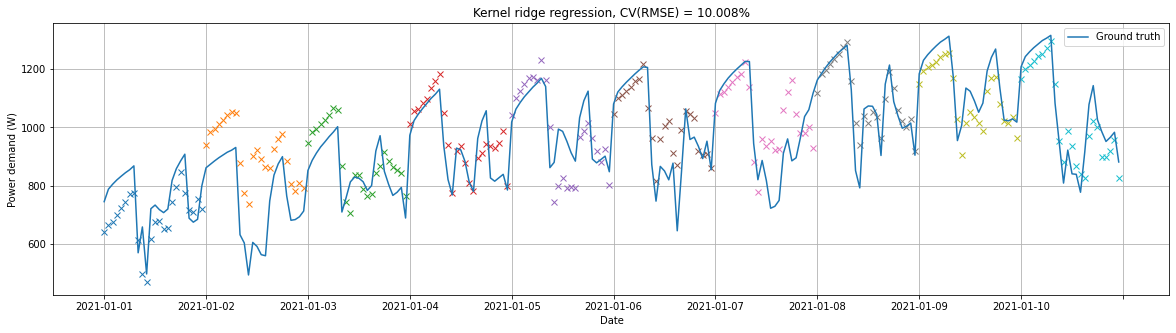

In [69]:
KRRreg_results = predictWithRetraining(method = KRRreg, name = "Kernel ridge regression")

# **Gaussian Process Regression**



Unlike many popular supervised machine learning algorithms that learn exact values for every parameter in a function, the probabilistic or Bayesian approach infers a probability distribution over all possible values. Let’s assume a simple linear function: $y=w\mathbf{x}+\epsilon$. The Bayesian approach works by specifying a prior distribution, $p(w)$, on the parameter, $w$, and relocating probabilities based on evidence (i.e., observed data $\mathbf{y, X}$ ) using Bayes’ theorem:
\begin{equation}
p(w|\mathbf{y, X}) = \frac{p(\mathbf{y|X},w)p(w)}{p(\mathbf{y|X})}
\end{equation}
The updated distribution $p(w|\mathbf{y, X})$, called the posterior distribution, thus incorporates information from both the prior distribution and the dataset. To get predictions at unseen points of interest, $\mathbf{x}^*$, the predictive distribution can be calculated by weighting all possible predictions by their calculated posterior distribution:
\begin{equation}
p(f^*|\mathbf{x}^*, \mathbf{y, X}) = \int_w p(f^*|\mathbf{x}^*, w) p(w|\mathbf{y, X}) dw
\end{equation}
The prior and likelihood is usually assumed to be Gaussian for the integration to be tractable. Using that assumption and solving for the predictive distribution, we get a Gaussian distribution, from which we can obtain a point prediction using its mean and an uncertainty quantification using its variance.

Gaussian process regression (GPR) is nonparametric (i.e., not limited by a functional form), so rather than calculating the probability distribution of parameters of a specific function, GPR calculates the probability distribution over *all* admissible functions that fit the data. However, similar to the above, we specify a prior (on the function space), calculate the posterior using the training data, and compute the predictive posterior distribution on our points of interest.

In GPR, we first assume a Gaussian process prior, which can be specified using a mean function, $m(x)$, and covariance function, $k(x, x’)$:
\begin{equation}
f(\mathbf{x}) = \mathcal{GP}(m(\mathbf{x}),k(\mathbf{x}, \mathbf{x}’))
\end{equation}

More specifically, a Gaussian process is like an infinite-dimensional multivariate Gaussian distribution, where any collection of the labels (response variables) of the dataset are jointly Gaussian distributed. Within this GP prior, we can incorporate prior knowledge about the space of functions through the selection of the mean and covariance functions. We can also easily incorporate independently, identically distributed (i.i.d) Gaussian noise, $\epsilon ∼ \mathcal{N}(0, \sigma^2)$, to the labels by summing the label distribution and noise distribution:
\begin{equation}
f(\mathbf{x}) = \mathcal{GP}(m(\mathbf{x}),k(\mathbf{x}, \mathbf{x}’) + \delta_{ij} \sigma_n^2)
\end{equation}

The dataset consists of observations, $\mathbf{X}$, and their labels, $\mathbf{y}$, split into training and testing subsets, the latter here designated with a star (*). From the Gaussian process prior, the collection of training points and test points are a joint multivariate Gaussian distribution, and their distribution in this way.

\begin{eqnarray}
\begin{bmatrix}
y \\ f^*
\end{bmatrix}
\sim  \mathcal{N}
\left ( 
\begin{bmatrix}
\mu \\ \mu*
\end{bmatrix},
\begin{bmatrix}
K(X,X))+\sigma_n^2 I& K(X,X^*)\\ 
K(X,X^*)) & K(X^*,X^*)
\end{bmatrix} 
\right )
\end{eqnarray}
Here, as before in the case of KRR, $K$ is the covariance kernel matrix where its entries correspond to the covariance (kernel) function evaluated at the observations. Written in this way, we can take the training subset to perform model selection.

The form of the mean function and covariance kernel function in the GP prior is chosen and tuned during model selection. The mean function is typically constant, either zero or the mean of the training dataset. There are many options for the covariance kernel function: it can have many forms as long as it follows the properties of a kernel (i.e., semi-positive definite and symmetric). Some common kernel functions include constant, linear, the common radial basis function (squared exponential) and Matern kernel, as well as a composition of multiple kernels. A popular kernel is the composition of the constant kernel with the radial basis function (RBF) kernel, which encodes for smoothness of functions (i.e., similarity of inputs in space corresponds to the similarity of outputs):

\begin{equation}
k(\mathbf{x},\mathbf{x}') = \sigma_f^2 \exp(-\frac{||\mathbf{x} - \mathbf{x}'||^2}{2 L^2})
\end{equation}
This kernel has two hyperparameters: signal variance, $\sigma_f^2$, and length scale, $L$. In scikit-learn, we can chose from a variety of kernels and specify the initial value and bounds on their hyperparameters.

```
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
```

After specifying the kernel function, we can now specify other choices for the GP model in scikit-learn. For example, `alpha` is the variance of the i.i.d. noise on the labels, and `normalize_y` refers to the constant mean function — either zero if False or the training data mean if True.

```
model = gp.GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer = 10, alpha = 0.1, normalize_y = True)
```

A popular approach to tune the hyperparameters of the covariance kernel function is to maximize the log marginal likelihood of the training data. A gradient-based optimizer is typically used for efficiency; if unspecified above, the default optimizer is `fmin_l_bfgs_b` (a limited memory quasi-Newton method approximating the Broyden–Fletcher–Goldfarb–Shanno algorithm). Because the log marginal likelihood is not necessarily convex, multiple restarts of the optimizer with different initializations is used (n_restarts_optimizer). The tuned hyperparameters of the kernel function can be obtained, if desired, by calling model.kernel_.get_params().

```
model.fit(X_train, y_train)
params = model.kernel_.get_params()
```

To calculate the predictive posterior distribution, the data and the test observation is conditioned out of the posterior distribution. Again, because we chose a Gaussian process prior, calculating the predictive distribution is tractable, and leads to normal distribution that can be completely described by the mean and covariance:

\begin{matrix}
f^*|X,y,X^* \sim \mathcal{N} \left( \bar{f}^*, \Sigma^*  \right )
\\ 
\bar{f}^* = \mu^*+K(X^*,X))\left [  K(X,X))+\sigma_n^2 I \right ]^{-1} \left ( y-\mu \right )
\\ 
\Sigma^* = K(X^*,X^*)-K(X^*,X)\left [  K(X,X))+\sigma_n^2 I \right ]^{-1}K(X,X^*)
\end{matrix}

Inference is simple to implement with sci-kit learn’s GPR predict function.

```
y_pred, std = model.predict(X_test, return_std = True)
```



In [74]:
# The code below is for testing purposes. There is an improvement when passing from 24 to 48 lags, slightly better again for 72 lags, I have stopped at 96. No big difference for non hourly lags.  
# Training time, however, is more erratic. 10 to 20 days provides erratic results. Over 30 days brings no improvement but makes the fitting step considerably longer.
# The data pre-processing step would need some more testing, to understand how it influences GP regression. 
gpreg_data, gpreg_step = resampleData(sampling = '1-hour')
gpreg_data = generateLagged(hours_into_the_past = 24, step = gpreg_step, data = gpreg_data)
X_train, y_train, X_test, y_test, X_test_m, y_test_m, trainxlabels, testxlabels, inp, out = generateTrainingAndTesting(Start = '2020-12-02', Training = 30, step = gpreg_step, data = gpreg_data)

Using sampling of 1-hour
For 24 hours, we introduce 24 lags


In [75]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, ExpSineSquared, RationalQuadratic, Matern, DotProduct

# Define the kernels separately

periodicity = ExpSineSquared(1, 2, (1e-3, 1e5)) * Matern() # Account for periodicity

local_disturbances = 1**2 * RationalQuadratic() # Account for local disturbances in the periodic signal

noise = 1**2 * Matern() + WhiteKernel(1e-1, (1e-4, 5)) # Add white noise

# Below, the "outsideConditions" kernel does not show significant change between a ConstantKernel and a DotProduct. Why?

#outsideConditions = ConstantKernel()**2

outsideConditions = DotProduct() # Include the effects of OA temperature and GHI.

# Assemble the kernel using the definitions above. Note: the kernels do not all have bounds for their optimization variables yet.

kernel = outsideConditions * periodicity + outsideConditions * local_disturbances + noise

GPRreg = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=10)
GPRreg.fit(X_train, y_train)
params = GPRreg.kernel_.get_params()
print(params)
prediction_gpr = GPRreg.predict(X_test_m)
print("The training score is %.4f and the testing score is %.4f" % (GPRreg.score(X_train, y_train), GPRreg.score(X_test_m, y_test_m)))

{'k1': DotProduct(sigma_0=7.5e+04) * ExpSineSquared(length_scale=7.85e+04, periodicity=3.15e+03) * Matern(length_scale=1e+05, nu=1.5) + DotProduct(sigma_0=5.68) * 0.0311**2 * RationalQuadratic(alpha=630, length_scale=0.00141), 'k2': 53.5**2 * Matern(length_scale=0.0002, nu=1.5) + WhiteKernel(noise_level=0.0124), 'k1__k1': DotProduct(sigma_0=7.5e+04) * ExpSineSquared(length_scale=7.85e+04, periodicity=3.15e+03) * Matern(length_scale=1e+05, nu=1.5), 'k1__k2': DotProduct(sigma_0=5.68) * 0.0311**2 * RationalQuadratic(alpha=630, length_scale=0.00141), 'k1__k1__k1': DotProduct(sigma_0=7.5e+04), 'k1__k1__k2': ExpSineSquared(length_scale=7.85e+04, periodicity=3.15e+03) * Matern(length_scale=1e+05, nu=1.5), 'k1__k1__k1__sigma_0': 74966.7845705404, 'k1__k1__k1__sigma_0_bounds': (1e-05, 100000.0), 'k1__k1__k2__k1': ExpSineSquared(length_scale=7.85e+04, periodicity=3.15e+03), 'k1__k1__k2__k2': Matern(length_scale=1e+05, nu=1.5), 'k1__k1__k2__k1__length_scale': 78484.80723725616, 'k1__k1__k2__k1__p

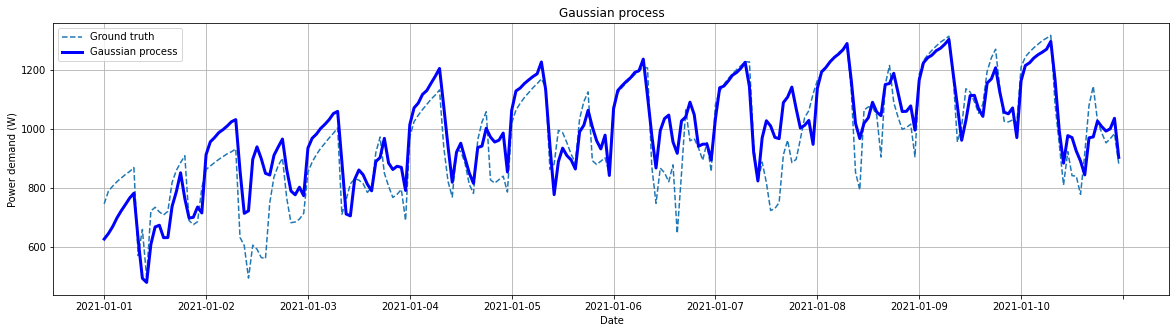

In [76]:
singlePredPlot(y_test_m = y_test_m, predictions = GPRreg.predict(X_test_m), testxlabels = testxlabels, labels = "Gaussian process", step = step, length = 10)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


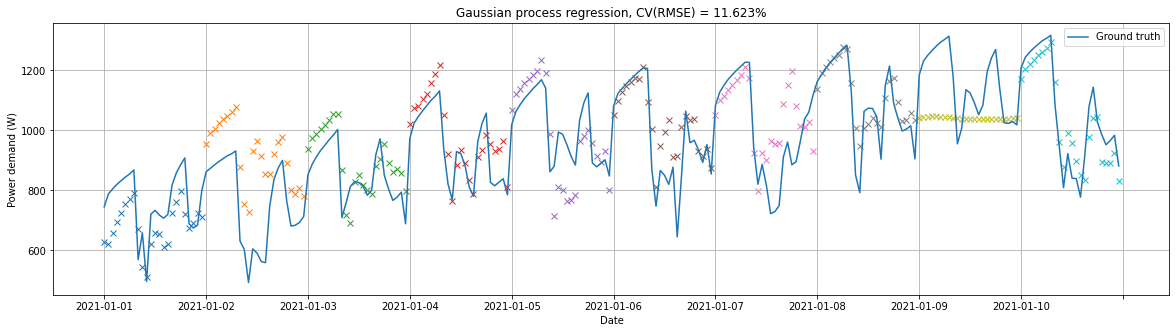

In [73]:
gpr_results = predictWithRetraining(method = GPRreg, name = "Gaussian process regression")
# Why do we have quasi-constant predictions on day 1 and day 7?

# That is all we have to show for today, thank you for listening.

# **Timing and memory usage**

This section shows the performance of the different approaches in terms of execution time and memory usage.

In [ ]:
try:
  import memory_profiler
except:
  !pip install memory_profiler
  import memory_profiler
%load_ext memory_profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-py3-none-any.whl size=30190 sha256=cb0f8046f7d2ed52b64e238919b317158ab519c106cf531174f83cb0d16821e5
  Stored in directory: /root/.cache/pip/wheels/56/19/d5/8cad06661aec65a04a0d6785b1a5ad035cb645b1772a4a0882
Successfully built memory-profiler


In [ ]:
print("Resource usage:\n\n")
print("TRAINING:")
print("\nLinear regression:")
%timeit -c LinearRegression().fit(X_train, y_train)
%memit -c LinearRegression().fit(X_train, y_train)
lreg = LinearRegression().fit(X_train, y_train)

print("\nLasso regression:")
%timeit -c LassoCV(cv=5, max_iter = 5000, random_state=0).fit(X_train, y_train)
%memit -c LassoCV(cv=5, max_iter = 5000, random_state=0).fit(X_train, y_train)
lassoreg = LassoCV(cv=5, max_iter = 5000, random_state=0).fit(X_train, y_train)

print("\nSingle pruned tree:")
%timeit -c DecisionTreeRegressor(random_state=0, ccp_alpha=best_alpha).fit(X_train, y_train)
%memit -c DecisionTreeRegressor(random_state=0, ccp_alpha=best_alpha).fit(X_train, y_train)
prunedreg = DecisionTreeRegressor(random_state=0, ccp_alpha=best_alpha).fit(X_train, y_train)

print("\nTree bagging:")
%timeit -c BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100).fit(X_train, y_train)
%memit -c BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100).fit(X_train, y_train)
baggedreg = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100).fit(X_train, y_train)

print("\nRandom patches:")
%timeit -c BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100, bootstrap_features = True).fit(X_train, y_train)
%memit -c BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100, bootstrap_features = True).fit(X_train, y_train)
randompatchesreg = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100, bootstrap_features = True).fit(X_train, y_train)

print("\nRandom forest:")
%timeit -c RandomForestRegressor(n_estimators=100, max_features = 1/3).fit(X_train, y_train)
%memit -c RandomForestRegressor(n_estimators=100, max_features = 1/3).fit(X_train, y_train)
randomforestreg = RandomForestRegressor(n_estimators=100, max_features = 1/3).fit(X_train, y_train)

print("\nBoosting:")
%timeit -c AdaBoostRegressor(tree.DecisionTreeRegressor(max_depth = 2), learning_rate = 0.1, n_estimators=5000).fit(X_train, y_train)
%memit -c AdaBoostRegressor(tree.DecisionTreeRegressor(max_depth = 2), learning_rate = 0.1, n_estimators=5000).fit(X_train, y_train)
boostreg = AdaBoostRegressor(tree.DecisionTreeRegressor(max_depth = 2), learning_rate = 0.1, n_estimators=5000).fit(X_train, y_train)

print("\nSupport Vector Regression:")
%timeit -c make_pipeline(StandardScaler(), GridSearchCV(SVR(kernel='rbf', epsilon=0.1),param_grid={"C": [1e-1, 1e0, 1e1, 1e2, 1e3],"gamma": [0.25, 0.1, 0.01],"epsilon": [0.1, 0.25, 0.5]})).fit(X_train, y_train)
%memit -c make_pipeline(StandardScaler(), GridSearchCV(SVR(kernel='rbf', epsilon=0.1),param_grid={"C": [1e-1, 1e0, 1e1, 1e2, 1e3],"gamma": [0.25, 0.1, 0.01],"epsilon": [0.1, 0.25, 0.5]})).fit(X_train, y_train)
svreg = make_pipeline(StandardScaler(), GridSearchCV(SVR(kernel='rbf', epsilon=0.1),param_grid={"C": [1e-1, 1e0, 1e1, 1e2, 1e3],"gamma": [0.25, 0.1, 0.01],"epsilon": [0.1, 0.25, 0.5]})).fit(X_train, y_train)

print("\nKernel Ridge Regression:")
%timeit -c GridSearchCV(KernelRidge(), param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],"kernel": [RBF(lengthscale)for lengthscale in np.logspace(-5, 5, 20)]}).fit(X_train, y_train)
%memit -c GridSearchCV(KernelRidge(), param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],"kernel": [RBF(lengthscale)for lengthscale in np.logspace(-5, 5, 20)]}).fit(X_train, y_train)
krreg = GridSearchCV(KernelRidge(), param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],"kernel": [RBF(lengthscale)for lengthscale in np.logspace(-5, 5, 20)]}).fit(X_train, y_train)

print("\nGaussian Process Regression:")
%timeit -c GaussianProcessRegressor(kernel = ExpSineSquared(1, 2, (1e-3, 1e5)) * Matern() * DotProduct() + DotProduct()*1**2 * RationalQuadratic() + 1**2 * Matern() + WhiteKernel(1e-1, (1e-4, 5)), n_restarts_optimizer=10).fit(X_train, y_train)
%memit -c GaussianProcessRegressor(kernel = ExpSineSquared(1, 2, (1e-3, 1e5)) * Matern() * DotProduct() + DotProduct()*1**2 * RationalQuadratic() + 1**2 * Matern() + WhiteKernel(1e-1, (1e-4, 5)), n_restarts_optimizer=10).fit(X_train, y_train)
GPRreg = GaussianProcessRegressor(kernel = ExpSineSquared(1, 2, (1e-3, 1e5)) * Matern() * DotProduct() + DotProduct()*1**2 * RationalQuadratic() + 1**2 * Matern() + WhiteKernel(1e-1, (1e-4, 5)), n_restarts_optimizer=10).fit(X_train, y_train)

print("TESTING:")
print("\nLinear regression:")
%timeit -c lreg.predict(X_test)
%memit -c lreg.predict(X_test)

print("\nLasso regression:")
%timeit -c lassoreg.predict(X_test)
%memit -c lassoreg.predict(X_test)

print("\nSingle pruned tree:")
%timeit -c prunedreg.predict(X_test)
%memit -c prunedreg.predict(X_test)

print("\nTree bagging:")
%timeit -c baggedreg.predict(X_test)
%memit -c baggedreg.predict(X_test)

print("\nRandom patches:")
%timeit -c randompatchesreg.predict(X_test)
%memit -c randompatchesreg.predict(X_test)

print("\nRandom forest:")
%timeit -c randomforestreg.predict(X_test)
%memit -c randomforestreg.predict(X_test)

print("\nBoosting:")
%timeit -c boostreg.predict(X_test)
%memit -c boostreg.predict(X_test)

print("\nSupport Vector Regression:")
%timeit -c svreg.predict(X_test)
%memit -c svreg.predict(X_test)

print("\nKernel Ridge Regression:")
%timeit -c krreg.predict(X_test)
%memit -c krreg.predict(X_test)

print("\nGaussian Process Regression:")
%timeit -c GPRreg.predict(X_test)
%memit -c GPRreg.predict(X_test)

Resource usage:


TRAINING:

Linear regression:
100 loops, best of 5: 3.87 ms per loop
peak memory: 518.20 MiB, increment: 0.00 MiB

Lasso regression:
1 loop, best of 5: 315 ms per loop
peak memory: 518.20 MiB, increment: 0.00 MiB

Single pruned tree:
10 loops, best of 5: 26 ms per loop
peak memory: 518.20 MiB, increment: 0.00 MiB

Tree bagging:
1 loop, best of 5: 1.45 s per loop
peak memory: 518.20 MiB, increment: 0.00 MiB

Random patches:
1 loop, best of 5: 1.45 s per loop
peak memory: 518.20 MiB, increment: 0.00 MiB

Random forest:
1 loop, best of 5: 579 ms per loop
peak memory: 518.20 MiB, increment: 0.00 MiB

Boosting:
1 loop, best of 5: 7.38 s per loop
peak memory: 518.63 MiB, increment: 0.08 MiB

Support Vector Regression:
1 loop, best of 5: 17.4 s per loop
peak memory: 518.63 MiB, increment: 0.00 MiB

Kernel Ridge Regression:
1 loop, best of 5: 27.6 s per loop
peak memory: 518.65 MiB, increment: 0.00 MiB

Gaussian Process Regression:
The slowest run took 8.02 times longer than 

# **Tests on lagged variables**

In [ ]:
def testLagging(method, samples = ["5-minutes", "15-minutes", "30-minutes", "1-hour"]):
  samplingComparison = {}
  metrics = {}
  y_tests = {}
  for sample in samples:
    samplingComparison[sample] = {}
    metrics[sample] = {}

  for sampling in samples:
    temp_data, step = resampleData(sampling = sampling)
    temp_data_hourly = generateLagged(hourly_lag = True, step = step, data = temp_data)
    X_train, y_train, X_test, y_test, X_test_m, y_test_m, trainxlabels, testxlabels, inp, out = generateTrainingAndTesting(step = step, data = temp_data_hourly)
    reg_temp = method.fit(X_train, y_train)
    samplingComparison[sampling]['hourly'] = reg_temp.predict(X_test_m)
    metrics[sampling]['hourly'] = r2_score(y_test_m, samplingComparison[sampling]['hourly'])*100


    temp_data, step = resampleData(sampling = sampling)
    temp_data_not_hourly = generateLagged(hourly_lag = False, step = step, data = temp_data)
    X_train, y_train, X_test, y_test, X_test_m, y_test_m, trainxlabels, testxlabels, inp, out = generateTrainingAndTesting(step = step, data = temp_data_not_hourly)
    reg_temp = method.fit(X_train, y_train) 
    pred_temp = reg_temp.predict(X_test_m)
    samplingComparison[sampling]['allLags'] = reg_temp.predict(X_test_m)
    metrics[sampling]['allLags'] = r2_score(y_test_m, samplingComparison[sampling]['allLags'])*100

    temp_data, step = resampleData(sampling = sampling)
    X_train, y_train, X_test, y_test, X_test_m, y_test_m, trainxlabels, testxlabels, inp, out = generateTrainingAndTesting(step = step, data = temp_data)
    reg_temp = method.fit(X_train, y_train)
    samplingComparison[sampling]['noLags'] = reg_temp.predict(X_test_m)
    metrics[sampling]['noLags'] = r2_score(y_test_m, samplingComparison[sampling]['noLags'])*100  
    y_tests[sampling] = y_test_m
  return samplingComparison, metrics, y_tests

TODO: Add here a loop that tries ALL regressors using the testLagging function and stores the results in a big data structure, rather than doing it regressor by regressor. Then, plot the results. 

In [ ]:
OLSsamplingComparison, OLSmetrics, y_tests = testLagging(method = LinearRegression())

Using sampling of 5-minutes
For 24 hours, we introduce 24 lags
Using sampling of 5-minutes
For 24 hours, we introduce 288 lags
Using sampling of 5-minutes
Using sampling of 15-minutes
For 24 hours, we introduce 24 lags
Using sampling of 15-minutes
For 24 hours, we introduce 96 lags
Using sampling of 15-minutes
Using sampling of 30-minutes
For 24 hours, we introduce 24 lags
Using sampling of 30-minutes
For 24 hours, we introduce 48 lags
Using sampling of 30-minutes
Using sampling of 1-hour
For 24 hours, we introduce 24 lags
Using sampling of 1-hour
For 24 hours, we introduce 24 lags
Using sampling of 1-hour


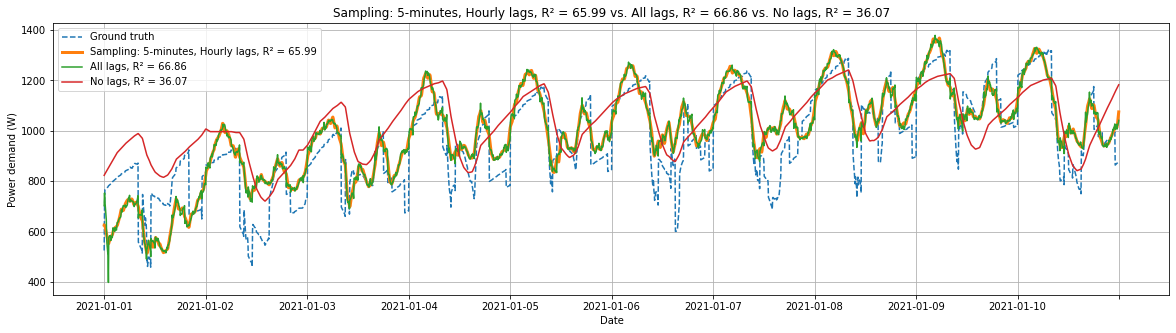

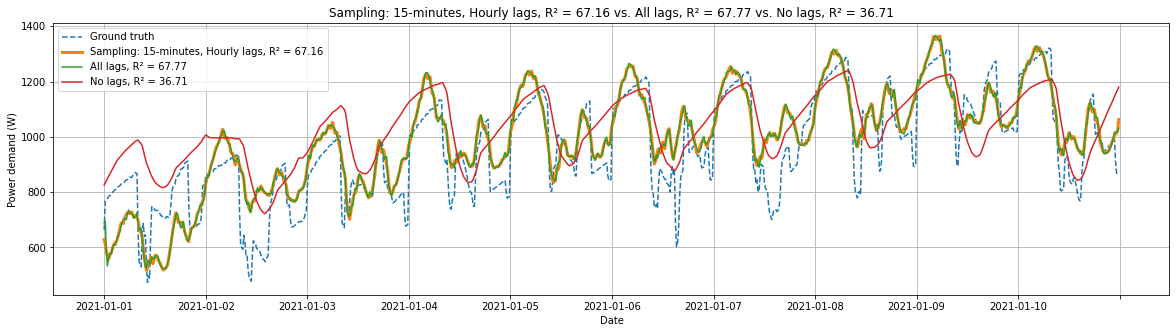

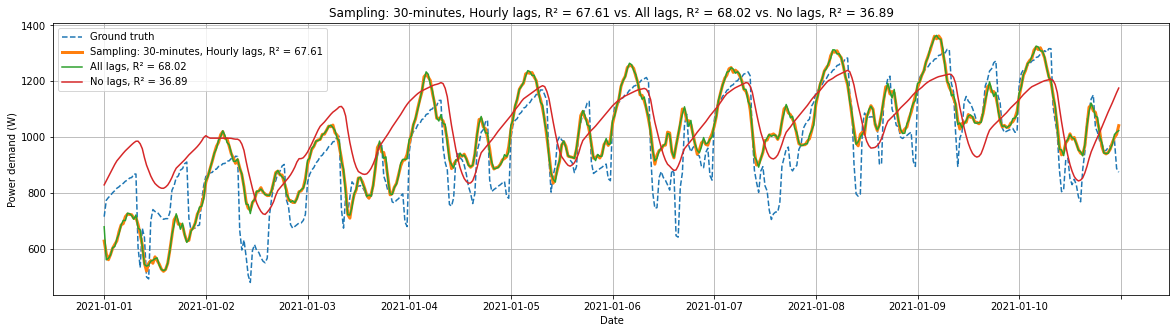

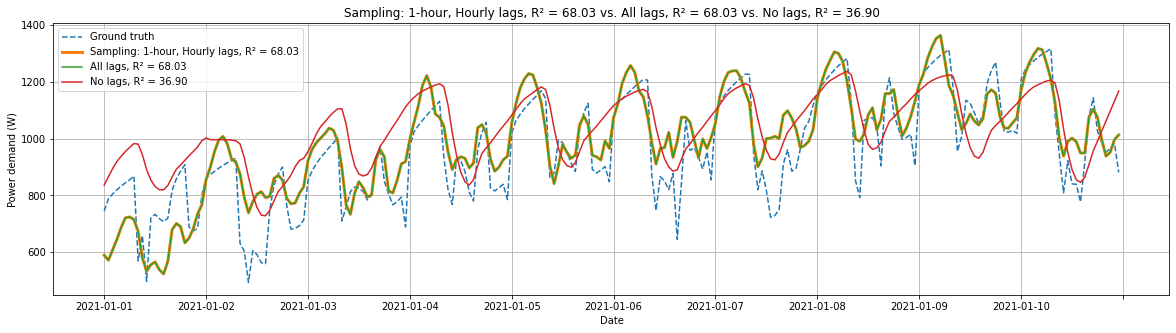

In [ ]:
samples = ["5-minutes", "15-minutes", "30-minutes", "1-hour"]
steps = {"5-minutes" : 300, "15-minutes" : 900, "30-minutes" : 1800, "1-hour" : 3600}
for sampling in samples:
  singlePredPlot(y_tests[sampling], [OLSsamplingComparison[sampling]['hourly'], OLSsamplingComparison[sampling]['allLags'], OLSsamplingComparison[sampling]['noLags']], ["Sampling: %s, Hourly lags, R² = %.2f" % (sampling, OLSmetrics[sampling]['hourly']), "All lags, R² = %.2f" % OLSmetrics[sampling]['allLags'], "No lags, R² = %.2f" % OLSmetrics[sampling]['noLags']], testxlabels, steps[sampling])

In [ ]:
LASSOsamplingComparison, LASSOmetrics, y_tests = testLagging(method = LassoCV(cv=5, max_iter = 5000, random_state=0))

Using sampling of 5-minutes
For 24 hours, we introduce 24 lags
Using sampling of 5-minutes
For 24 hours, we introduce 288 lags


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71233.93204298615, tolerance: 40214.530465519514
  tol, rng, random, positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125614.34868398309, tolerance: 52432.803715310954
  positive)


Using sampling of 5-minutes
Using sampling of 15-minutes
For 24 hours, we introduce 24 lags
Using sampling of 15-minutes
For 24 hours, we introduce 96 lags


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13137.765733994544, tolerance: 11426.530558339946
  tol, rng, random, positive)


Using sampling of 15-minutes
Using sampling of 30-minutes
For 24 hours, we introduce 24 lags
Using sampling of 30-minutes
For 24 hours, we introduce 48 lags
Using sampling of 30-minutes
Using sampling of 1-hour
For 24 hours, we introduce 24 lags
Using sampling of 1-hour
For 24 hours, we introduce 24 lags
Using sampling of 1-hour


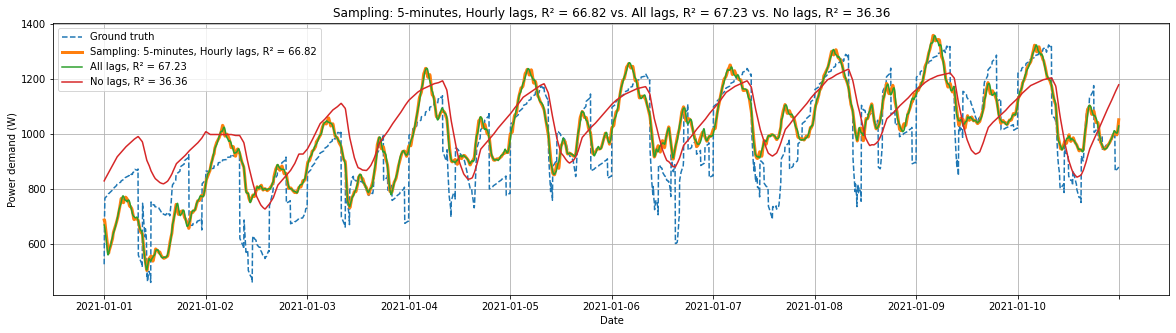

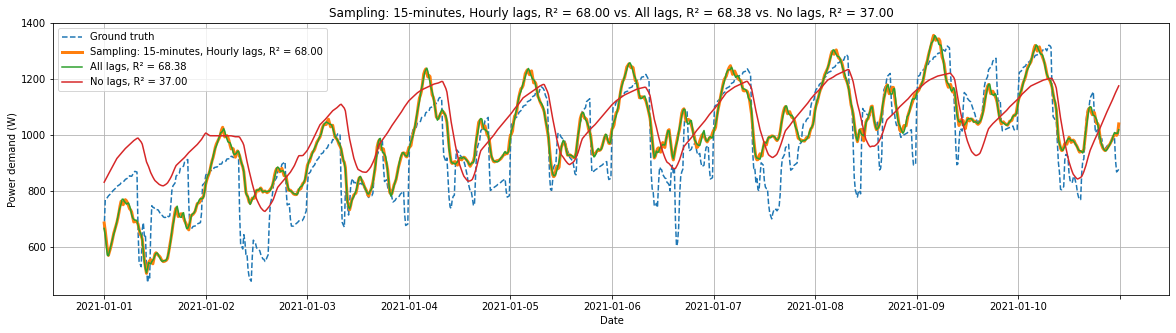

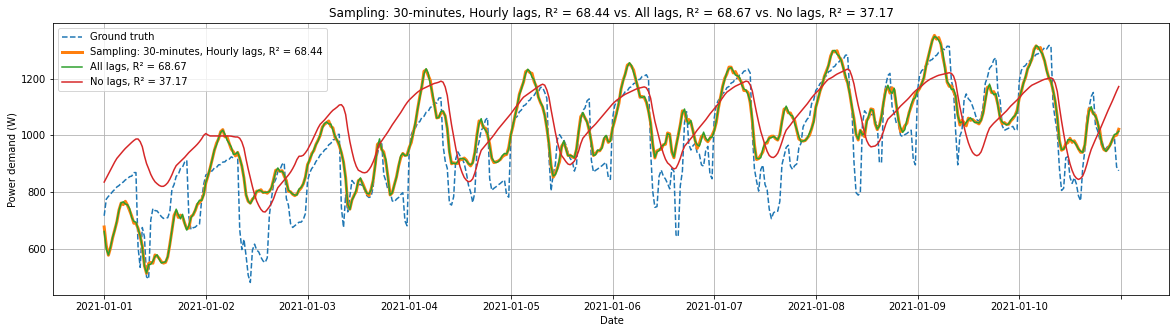

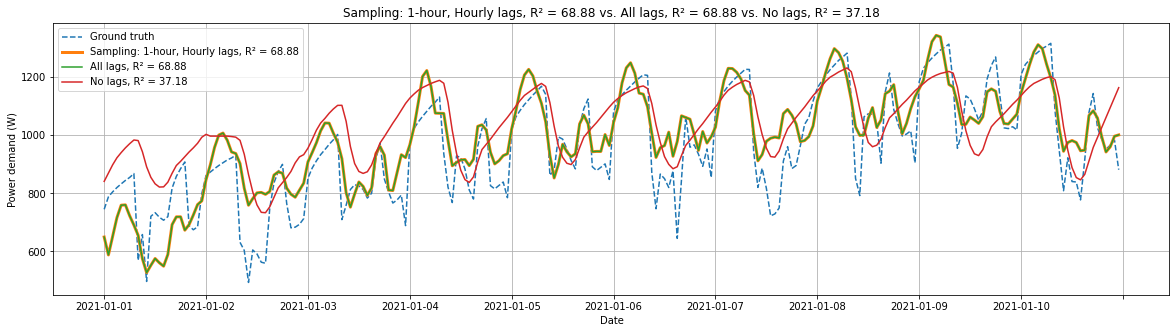

In [ ]:
samples = ["5-minutes", "15-minutes", "30-minutes", "1-hour"]
steps = {"5-minutes" : 300, "15-minutes" : 900, "30-minutes" : 1800, "1-hour" : 3600}
for sampling in samples:
  singlePredPlot(y_tests[sampling], [LASSOsamplingComparison[sampling]['hourly'], LASSOsamplingComparison[sampling]['allLags'], LASSOsamplingComparison[sampling]['noLags']], ["Sampling: %s, Hourly lags, R² = %.2f" % (sampling, LASSOmetrics[sampling]['hourly']), "All lags, R² = %.2f" % LASSOmetrics[sampling]['allLags'], "No lags, R² = %.2f" % LASSOmetrics[sampling]['noLags']], testxlabels, steps[sampling])

In [ ]:
RRsamplingComparison, RRmetrics, y_tests = testLagging(method =  RidgeCV(cv = 5, alphas=np.logspace(-6, 10, 17)))

Using sampling of 5-minutes
For 24 hours, we introduce 24 lags
Using sampling of 5-minutes
For 24 hours, we introduce 288 lags


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.01339e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.00732e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.96218e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.69128e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.6137e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlg

Using sampling of 5-minutes
Using sampling of 15-minutes
For 24 hours, we introduce 24 lags
Using sampling of 15-minutes
For 24 hours, we introduce 96 lags
Using sampling of 15-minutes
Using sampling of 30-minutes
For 24 hours, we introduce 24 lags
Using sampling of 30-minutes
For 24 hours, we introduce 48 lags
Using sampling of 30-minutes
Using sampling of 1-hour
For 24 hours, we introduce 24 lags
Using sampling of 1-hour
For 24 hours, we introduce 24 lags
Using sampling of 1-hour


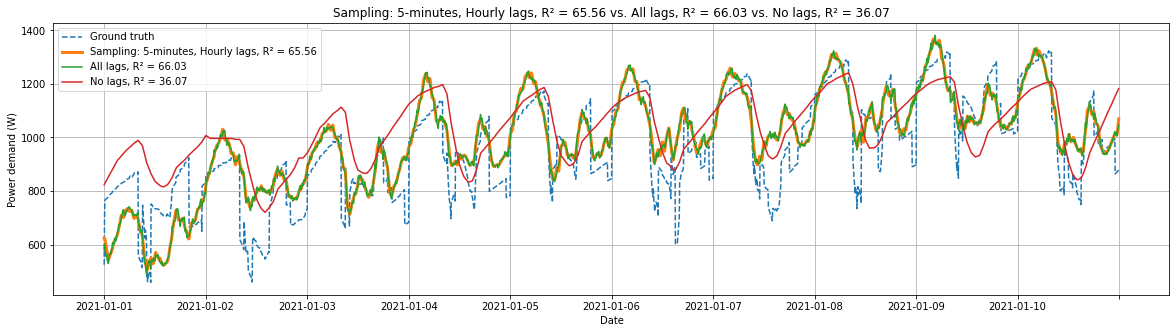

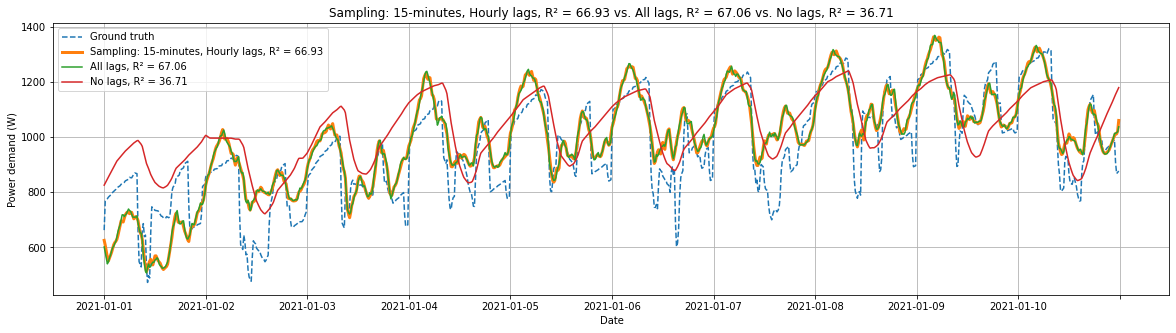

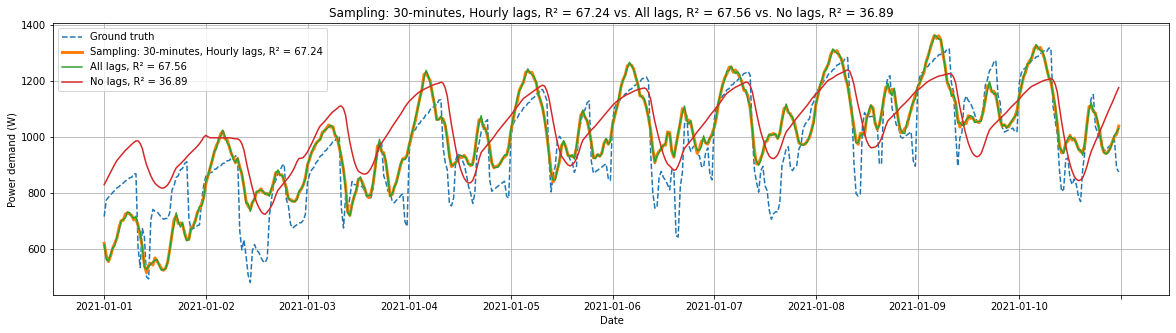

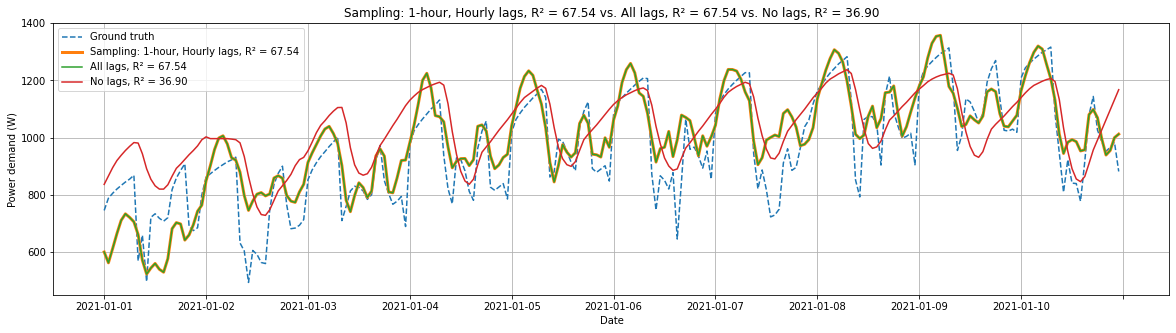

In [ ]:
samples = ["5-minutes", "15-minutes", "30-minutes", "1-hour"]
steps = {"5-minutes" : 300, "15-minutes" : 900, "30-minutes" : 1800, "1-hour" : 3600}
for sampling in samples:
  singlePredPlot(y_tests[sampling], [RRsamplingComparison[sampling]['hourly'], RRsamplingComparison[sampling]['allLags'], RRsamplingComparison[sampling]['noLags']], ["Sampling: %s, Hourly lags, R² = %.2f" % (sampling, RRmetrics[sampling]['hourly']), "All lags, R² = %.2f" % RRmetrics[sampling]['allLags'], "No lags, R² = %.2f" % RRmetrics[sampling]['noLags']], testxlabels, steps[sampling])